# Log of notebook

### Updates

-   24/04/2020 Applyng cuts in Sigma_str so agrees with previous scalling relations in the literature. In particular the rSFMS. Constrains of SNR were loosen, except for Ha and Hb. 


-   13/02/2020 Heavily based in P_hyd-S_SFR_Residuals_BA_0.45. **Same as P_hyd-S_SFR_Residuals but including the selection of BA > 0.45**


-   24/04/2020 MPL9_ALL_Resolved_SFRssp.npz NO MORPHOLOGY

### Description

-   Derive a relation between Sb and S_SFR

### Input

-  ../MPL9_ALL_Resolved_SFRssp.npz

### Output

In [1]:
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import optimize
from astropy.cosmology import WMAP9 as cosmo
from matplotlib.colors import LogNorm
from astropy.io import fits, ascii
from astropy.table import Table
#from astropy.stats.funcs import mad_std, biweight_location
from matplotlib.backends.backend_pdf import PdfPages
# import lmfit
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde, linregress, pearsonr, spearmanr, kendalltau, chi2_contingency
from matplotlib import rcParams as rc
from astroML.stats import binned_statistic_2d
from sel2dContour import sel2dContour_Open, quickContour
rc.update({'font.size': 23,\
           'font.weight': 900,\
           'text.usetex': True,\
           'xtick.labelsize' : 22,\
           'ytick.labelsize' : 22,\
           'xtick.major.size' : 5.5,\
           'ytick.major.size' : 5.5,\
           'axes.linewidth'  : 2.0,\
           
          })
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches': None}

In [2]:
######################################################################
# Interpolation. 
def interp(x, y, x_int):
    yinterp = np.interp(x_int, x, y)
    return(yinterp)

######################################################################
# Medians at bin with fixed size. 
def med(x,y,A):
    
    bin1 , min1 , max1= A[0], A[1], A[2] 
    
    x_range    = np.arange(min1,max1,bin1)
    y1_binM    = np.zeros(x_range.size)
    y1_binD    = np.zeros(x_range.size)

    for i, val  in enumerate(x_range):
        tmp = (x >= val) & (x <= val+bin1)
        y1_binM[i]   = np.median(y[tmp])
        y1_binD[i]   = np.std   (y[tmp])
        
    return(x_range+0.5*bin1, y1_binM, y1_binD)

##################################################################
# Model linear function 
def model_lin(params, x):
    a,b= params    
    y = a*x + b
    return y

# Function to minimize for model_lin
def fun_lin(params, x, y_data):
    return y_data - model_lin(params, x)

##################################################################
# Model function of x-axis with two parameters
def model_2par(params, x):
    a,b,c,d = params
    y = d*( a*x[0]**2.0 + b*x[0]*x[1] + c**x[1]**2.)
    return y

# Function to minimize for model_2par
def fun_2par(params, x, y_data):
    return y_data - model_2par(params, x)

##################################################################
# Model function of x-axis with two parameters with two terms
# THIS IS THE FUNCTIONAL FORM OF THE P_ism 
# x[0] HAS TO BE THE GAS!
def model_2par_2ter(params, x):
    a,b,d = params
    y = d*( a*x[0]**2.0 + b*x[0]*x[1])
    return y

# Function to minimize for model_2par
def fun_2par_2ter(params, x, y_data):
    return y_data - model_2par_2ter(params, x)

##################################################################
# Model function of x-axis with three parameters
def model_3par(params, x):
    a,b,c,d,f,g = params    
    y = d*( a*x[0]**2.0 + b*x[0]*x[1] + c**x[1]**2.) + f*x[2] + g*x[2]**2.0    
    return y

def fun_3par(params, x, y_data):
    return y_data - model_3par(params, x)

##################################################################
# Model function of x-axis with three parameters with two terms
def model_3par_2ter(params, x):
    a,b,d,f,g = params    
    y = d*( a*x[0]**2.0 + b*x[0]*x[1]) + f*x[2] + g*x[2]**2.0    
    return y

def fun_3par_2ter(params, x, y_data):
    return y_data - model_3par_2ter(params, x)

In [3]:
# Loading Data MPL-9

tab = np.load('../MPL9_ALL_Resolved_SFRssp.npz')

In [48]:
#Global
idt    = tab['idt' ]
Reff    = tab['Reff' ]
z_tot   = tab['z_tot']
Mstar   = tab['Mstar']
SFRtot  = tab['SFR_tot']
BA      = tab['BA' ]
# MorphN_tot = tab['MorphN_tot']
# MorphS_tot = tab['MorphS_tot']
#Spatial
y    = tab['y' ]
x    = tab['x' ]
d    = tab['d' ]
dpc  = tab['dpc' ]

# Stellar
Sigma_stellarE    = tab['Sigma_stellarE']
Sigma_stellar     = tab['Sigma_stellar' ]
AvSt              = tab['AvSt' ]
Sigma_SFRssp      = tab['Sigma_SFRssp'] - 0.6 #why 0.6 dex??? np.log10(0.5**2)
sSFRssp           = tab['sSFR_ssp']
#Lines
O3    = tab['O3']
O2    = tab['O2']
Hb    = tab['Hb']
Ha    = tab['Ha']
N2    = tab['N2']
S2_17 = tab['S2_17']
S2_31 = tab['S2_31']

# Error-Lines
O3E    = tab['O3E' ]
HaE    = tab['HaE' ]
N2E    = tab['N2E' ]
HbE    = tab['HbE' ]
O2E    = tab['O2E' ]
S2E_17 = tab['S2_17']
S2E_31 = tab['S2_31']

#Line ratios
N2Ha    = tab['N2Ha' ]
O3Hb    = tab['O3Hb' ]
O2Hb    = tab['O2Hb' ]

# Ha-derived
EW        = tab['EW']
Sigma_SFR = tab['Sigma_SFR' ]
Vesc      = tab['Vesc']
Vrot      = tab['Vrot']

In [49]:
#  & (N2E < 0.3*N2) & (O3E < 0.3*O3) & \
# (O2E < 0.3*O2) & (S2E_17 > 0.3*S2_17) & (S2E_31 > 0.3*S2_31)

# SF spaxels by BPT (Kewley+2006) & sSFRssp > -11.4 A & BA > 0.45 
idx_SF = (Sigma_stellar > 0.0) & (dpc > 0.0) & \
(sSFRssp > -10.0) & (np.abs(EW) > 10.0) & (Ha/Hb > 2.86) & (BA > 0.45) &  (HaE < 0.3*Ha) & \
(O3Hb < 0.61 / (N2Ha - 0.05) + 1.3) & (N2Ha < 0.05) & (HbE < 0.3*Hb)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [50]:
# Constant values 
K_Ha = 2.53
K_Hb = 3.61
K_av = K_Ha/(-0.4*(K_Ha-K_Hb))
Ha_sel = Ha#[idx_SF]
Hb_sel = Hb#[idx_SF]

Av     = K_av* np.log10((Ha_sel/Hb_sel)/2.86)/ 0.817

Sigma_Gas = 23*Av

In [51]:
# Svel_gas 

G = 4.30e-9 # Km^2 Mpc M_sun^-1 s^-2
G_pc = 1e6 * G

# Rotational Curve Index
beta  = 1.0
# epicyclic frequency
Omega = Vrot/ dpc
kappa = np.sqrt(2.0*(beta+1.0)) * Omega

#Gas Dispersion, assuming Q_g = 2
sgas = (2*np.pi*G_pc*Sigma_Gas)/kappa

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [136]:
# Further selection
idx1 = (Sigma_Gas[idx_SF] > 0) & np.isfinite(Sigma_SFRssp[idx_SF])

Sigma_Gas_sel = Sigma_Gas[idx_SF][idx1]
# Sigma_SFR_sel = Sigma_SFR[idx_SF][idx1]
Sigma_SFRssp_sel = Sigma_SFRssp[idx_SF][idx1]
Sigma_Str_sel = Sigma_stellar[idx_SF][idx1]
Sigma_SFR_sel = 10**(Sigma_SFRssp_sel)

# Statistics 
sel_gal = np.unique(idt[idx_SF][idx1])
num_gal = sel_gal.size
num_spa = Sigma_SFR_sel.size


print ('Number of All Galaxies      ', np.unique(idt).size)
print ('Number of Galaxies Selected ', num_gal)
print ('Number of All spaxels       ', num_spa)

Number of All Galaxies       7714
Number of Galaxies Selected  2330
Number of All spaxels        365738


In [137]:
Disp_Sigma_SFR = np.std(np.log10(Sigma_SFR_sel*1e6))
print ('Standard Deviation of Sigma_SFR :', Disp_Sigma_SFR)

Disp_Sigma_SFRssp = np.nanstd(Sigma_SFRssp_sel)
print ('Standard Deviation of Sigma_SFR :', Disp_Sigma_SFRssp)

Standard Deviation of Sigma_SFR : 0.6240758650301526
Standard Deviation of Sigma_SFR : 0.6240758650301527


In [138]:
G_astro = 6.67259e-8 # cgs
Sigma_Gas_sel_cgs = 2.21e-4*Sigma_Gas_sel
Sigma_Str_sel_cgs = 2.21e-4*Sigma_Str_sel

### P_ISM ###
p_ism = np.pi*0.5*G_astro*(Sigma_Gas_sel_cgs)*(Sigma_Gas_sel_cgs + 0.37*Sigma_Str_sel_cgs)


# SFR - P_hyd SFR:  from Ha and SSPs 

Text(0, 0.5, '$\\Sigma_\\mathrm{SFR}\\,\\log(\\mathrm{M_{\\odot}\\,\\,yr^{-1}\\,\\,kpc^{-2} })$')

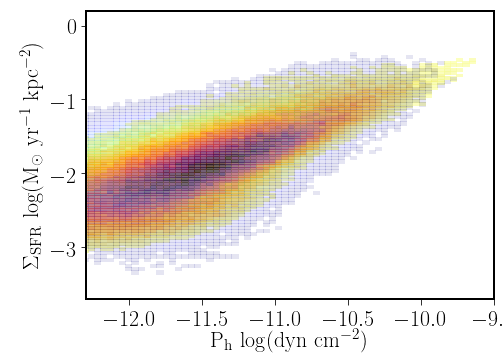

In [139]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

idx = np.isfinite(Sigma_SFRssp_sel) 

host.hist2d(np.log10(p_ism[idx]), np.log10(Sigma_SFR[idx_SF][idx1]*1e6), 
            cmin =20, bins = 200, cmap = 'inferno_r', alpha = 0.7)

host.hist2d(np.log10(p_ism), np.log10(Sigma_SFR_sel*1e6), 
            cmin =20, bins = 200, cmap = 'jet', alpha = 0.1)

host.set_ylim([-3.7,0.2])
host.set_xlim([-12.3,-9.5])
host.set_xlabel('$\mathrm{P_{h}}\,\log(\mathrm{dyn\,\,cm^{-2} })$', fontsize = 22)
host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)

# plt.savefig('plots/plot_SFRssp_Pism_v1.pdf')

In [159]:
paramW_sfr = [0.2, -3.0, -0.8]
xW_sfr,yWM_sfr,yWS_sfr   = med(np.log10(Sigma_SFR[idx_SF][idx1]*1e6), np.log10(Sigma_SFR_sel*1e6), paramW_sfr)

In [160]:
x0fit = [1,1]
fit_sfr , flag_lfit = optimize.leastsq(fun_lin, x0fit, 
                           args = (np.log10(Sigma_SFR[idx_SF][idx1]*1e6), np.log10(Sigma_SFR_sel*1e6)))

print('BEST FIT (BINS): ', fit_sfr , flag_lfit)

BEST FIT (BINS):  [ 0.80594231 -0.28537663] 2


In [162]:
x_plt, y_plt = np.log10(Sigma_SFR[idx_SF][idx1]*1e6), np.log10(Sigma_SFR_sel*1e6)
counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=150,
                                      normed=True,
                                      range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
counts /= counts.max()

1.3342034123108268 0.45124574837563763
0.7117225060381326


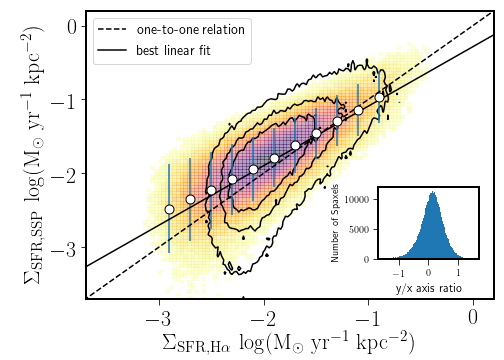

In [211]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])
ax1  = plt.axes([0.75, 0.28, 0.20, 0.20])
xtmp  = np.linspace(-5,1,1000)
host.hist2d(np.log10(Sigma_SFR[idx_SF][idx1]*1e6), np.log10(Sigma_SFR_sel*1e6),  
            cmin =20, bins = 200, cmap = 'inferno_r', alpha = 0.4)

host.contour(counts.transpose(), mylevels, 
             extent=(np.nanmin(x_plt),np.nanmax(x_plt),np.nanmin(y_plt),np.nanmax(y_plt)),
             linestyles='solid', colors = 'k')

host.errorbar(xW_sfr,yWM_sfr, yerr = yWS_sfr, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(xtmp, xtmp, '--k', label = 'one-to-one relation')
host.plot(xtmp, fit_sfr[0]*xtmp+fit_sfr[1], '-k', label = 'best linear fit')


sfr_ratio = np.log10(Sigma_SFR_sel*1e6) - np.log10(Sigma_SFR[idx_SF][idx1]*1e6)
ax1.hist( sfr_ratio, bins = 300)
host.set_xlim([-2.2,2.2])

print(10**np.median(sfr_ratio), np.std(sfr_ratio))
med1 = np.median(sfr_ratio)
ax1.plot([med1, med1], [0,24],  '--b')
ax1.set_xlabel('y/x axis ratio', fontsize=12)
ax1.set_ylabel('Number of Spaxels', fontsize=10)
ax1.set_xlim([-1.7,1.7])
ax1.tick_params(labelsize=10)

host.legend(loc = 2, fontsize = 14)
host.set_xlabel('$\Sigma_\mathrm{SFR,H\\alpha}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_ylabel('$\Sigma_\mathrm{SFR,SSP}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_ylim([-3.7,0.2])
host.set_xlim([-3.7,0.2])
# plt.savefig('plots/SFRs_comp.pdf')
# plt.savefig('plots/SFRs_comp.png')
stat_pea_SFRs, pea_SFRs = pearsonr (np.log10(Sigma_SFR_sel*1e6) , np.log10(Sigma_SFR[idx_SF][idx1]*1e6))
print(stat_pea_SFRs)

0.12522204705398576 0.45124574837563763


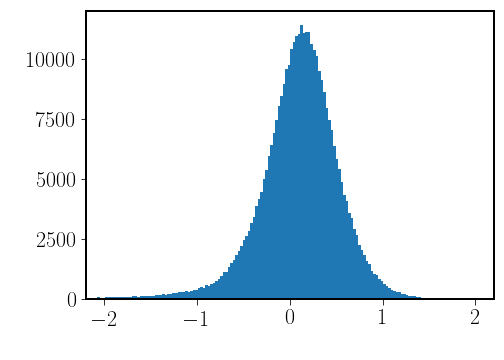

In [168]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])
sfr_ratio = np.log10(Sigma_SFR_sel*1e6) - np.log10(Sigma_SFR[idx_SF][idx1]*1e6)
host.hist( sfr_ratio, bins = 300)
host.set_xlim([-2.2,2.2])

print(np.median(sfr_ratio), np.std(sfr_ratio))

# ============ deriving correlation coefficients ============ 

### SFR vs  Sigma_gas



In [25]:
#SFR vs Sgas SFR_gas

stat_pea_SFR_Gas, pea_SFR_Gas = pearsonr  (np.log10(Sigma_Gas_sel), np.log10(Sigma_SFR_sel*1e6))
stat_spe_SFR_Gas, spe_SFR_Gas = spearmanr (np.log10(Sigma_Gas_sel), np.log10(Sigma_SFR_sel*1e6))
stat_ken_SFR_Gas, ken_SFR_Gas = kendalltau(np.log10(Sigma_Gas_sel), np.log10(Sigma_SFR_sel*1e6))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   SFR-Sstar:', stat_pea_SFR_Gas, pea_SFR_Gas)
print(' Spearman SFR-Sstar:', stat_spe_SFR_Gas, spe_SFR_Gas)
print(' Kendall  SFR-Sstar:', stat_ken_SFR_Gas, ken_SFR_Gas)

 Person   SFR-Sstar: 0.2640796653586427 0.0
 Spearman SFR-Sstar: 0.3167230732759098 0.0
 Kendall  SFR-Sstar: 0.216469793178553 0.0


### SFR vs SFR_stellar



In [26]:
stat_pea_SFR_Str, pea_SFR_Str = pearsonr  (np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_SFR_sel*1e6))
stat_spe_SFR_Str, spe_SFR_Str = spearmanr (np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_SFR_sel*1e6))
stat_ken_SFR_Str, ken_SFR_Str = kendalltau(np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_SFR_sel*1e6))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   SFR-Sstar:', stat_pea_SFR_Str, pea_SFR_Str)
print(' Spearman SFR-Sstar:', stat_spe_SFR_Str, spe_SFR_Str)
print(' Kendall  SFR-Sstar:', stat_ken_SFR_Str, ken_SFR_Str)

 Person   SFR-Sstar: 0.6437744344713556 0.0
 Spearman SFR-Sstar: 0.6816379616692511 0.0
 Kendall  SFR-Sstar: 0.49617958012277086 0.0


### SFR vs Sgas P_ism



In [27]:
stat_pea_SFR_Pism, pea_SFR_Pism = pearsonr  (np.log10(p_ism), np.log10(Sigma_SFR_sel*1e6))
stat_spe_SFR_Pism, spe_SFR_Pism = spearmanr (np.log10(p_ism), np.log10(Sigma_SFR_sel*1e6))
stat_ken_SFR_Pism, ken_SFR_Pism = kendalltau(np.log10(p_ism), np.log10(Sigma_SFR_sel*1e6))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   SFR-Pism:', stat_pea_SFR_Pism, pea_SFR_Pism)
print(' Spearman SFR-Pism:', stat_spe_SFR_Pism, spe_SFR_Pism)
print(' Kendall  SFR-Pism:', stat_ken_SFR_Pism, ken_SFR_Pism)

 Person   SFR-Pism: 0.4661309170236757 0.0
 Spearman SFR-Pism: 0.5113848659370653 0.0
 Kendall  SFR-Pism: 0.3567354424116548 0.0


# SFR vs Sb

In [28]:
stat_pea_SFR_Sb, pea_SFR_Sb = pearsonr  (np.log10((Sigma_Str_sel+Sigma_Gas_sel)*1e6), np.log10(Sigma_SFR_sel*1e6))
stat_spe_SFR_Sb, spe_SFR_Sb = spearmanr (np.log10((Sigma_Str_sel+Sigma_Gas_sel)*1e6), np.log10(Sigma_SFR_sel*1e6))
stat_ken_SFR_Sb, ken_SFR_Sb = kendalltau(np.log10((Sigma_Str_sel+Sigma_Gas_sel)*1e6), np.log10(Sigma_SFR_sel*1e6))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   SFR-Pism:', stat_pea_SFR_Sb, pea_SFR_Sb)
print(' Spearman SFR-Pism:', stat_spe_SFR_Sb, spe_SFR_Sb)
print(' Kendall  SFR-Pism:', stat_ken_SFR_Sb, ken_SFR_Sb)

 Person   SFR-Pism: 0.6233821032052114 0.0
 Spearman SFR-Pism: 0.6550445788384319 0.0
 Kendall  SFR-Pism: 0.47153959343272084 0.0


### SFR vs EW



In [29]:
stat_pea_SFR_EW, pea_SFR_EW = pearsonr  (np.log10(np.abs(EW[idx_SF][idx1])), np.log10(Sigma_SFR_sel*1e6))
stat_spe_SFR_EW, spe_SFR_EW = spearmanr (np.log10(np.abs(EW[idx_SF][idx1])), np.log10(Sigma_SFR_sel*1e6))
stat_ken_SFR_EW, ken_SFR_EW = kendalltau(np.log10(np.abs(EW[idx_SF][idx1])), np.log10(Sigma_SFR_sel*1e6))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   SFR-EW:', stat_pea_SFR_EW, pea_SFR_EW)
print(' Spearman SFR-EW:', stat_spe_SFR_EW, spe_SFR_EW)
print(' Kendall  SFR-EW:', stat_ken_SFR_EW, ken_SFR_EW)

 Person   SFR-EW: 0.13554826951264407 0.0
 Spearman SFR-EW: 0.14069533816784502 0.0
 Kendall  SFR-EW: 0.09390156403752162 0.0


### EW(Ha) vs  Sigma_gas



In [30]:
stat_pea_EW_Gas, pea_EW_Gas = pearsonr  (np.log10(Sigma_Gas_sel), np.log10(np.abs(EW[idx_SF][idx1])))
stat_spe_EW_Gas, spe_EW_Gas = spearmanr (np.log10(Sigma_Gas_sel), np.log10(np.abs(EW[idx_SF][idx1])))
stat_ken_EW_Gas, ken_EW_Gas = kendalltau(np.log10(Sigma_Gas_sel), np.log10(np.abs(EW[idx_SF][idx1])))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   EW-Sgas:', stat_pea_EW_Gas, pea_EW_Gas)
print(' Spearman EW-Sgas:', stat_spe_EW_Gas, spe_EW_Gas)
print(' Kendall  EW-Sgas:', stat_ken_EW_Gas, ken_EW_Gas)

 Person   EW-Sgas: -0.14847607812498909 0.0
 Spearman EW-Sgas: -0.18673347729754686 0.0
 Kendall  EW-Sgas: -0.12582745768556453 0.0


### EW(Ha) vs  Sigma_star



In [31]:
stat_pea_EW_Sstr, pea_EW_Sstr = pearsonr  (np.log10(Sigma_Str_sel*1e6), np.log10(np.abs(EW[idx_SF][idx1])))
stat_spe_EW_Sstr, spe_EW_Sstr = spearmanr (np.log10(Sigma_Str_sel*1e6), np.log10(np.abs(EW[idx_SF][idx1])))
stat_ken_EW_Sstr, ken_EW_Sstr = kendalltau(np.log10(Sigma_Str_sel*1e6), np.log10(np.abs(EW[idx_SF][idx1])))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   EW-Star:', stat_pea_EW_Sstr, pea_EW_Sstr)
print(' Spearman EW-Star:', stat_spe_EW_Sstr, spe_EW_Sstr)
print(' Kendall  EW-Star:', stat_ken_EW_Sstr, ken_EW_Sstr)

 Person   EW-Star: -0.09633147655811239 0.0
 Spearman EW-Star: -0.07638037399319897 0.0
 Kendall  EW-Star: -0.05081449210148335 0.0


### EW(Ha) vs P_ism



In [32]:
stat_pea_EW_Pism, pea_EW_Pism = pearsonr  (np.log10(p_ism), np.log10(np.abs(EW[idx_SF][idx1])))
stat_spe_EW_Pism, spe_EW_Pism = spearmanr (np.log10(p_ism), np.log10(np.abs(EW[idx_SF][idx1])))
stat_ken_EW_Pism, ken_EW_Pism = kendalltau(np.log10(p_ism), np.log10(np.abs(EW[idx_SF][idx1])))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   EW-Pism:', stat_pea_EW_Pism, pea_EW_Pism)
print(' Spearman EW-Pism:', stat_spe_EW_Pism, spe_EW_Pism)
print(' Kendall  EW-Pism:', stat_ken_EW_Pism, ken_EW_Pism)

 Person   EW-Pism: -0.14163697134427367 0.0
 Spearman EW-Pism: -0.14850777523832445 0.0
 Kendall  EW-Pism: -0.09912505400890471 0.0


# ============ Minimization x= S_stellar, SFMS =================

In [33]:
# Select 80% sample
#x1_sel,y1_sel, index1_sel, contour1_sel = sel2dContour_Open(np.log10(Sigma_Str_sel*1e6), 
#                                                            np.log10(Sigma_SFR_sel*1e6),
#                                                            ld = True )

In [183]:
paramW_rSFMS = [0.2, 6.5, 9.0]
#xW,yWM,yWS   = med(x1_sel,y1_sel,paramW_rSFMS)
xW_SFMS,yWM_SFMS,yWS_SFMS   = med(np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_SFR_sel*1e6),paramW_rSFMS)

paramN_rSFMS = [0.01, 6.5, 9.0]
#xN,yNM,yNS   = med(x1_sel,y1_sel,paramN_rSFMS)
xN_SFMS,yNM_SFMS,yNS_SFMS   = med(np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_SFR_sel*1e6),paramN_rSFMS)


In [184]:
#path_90, path_80, path_60 = contour1_sel.collections[0].get_paths()[0],\
#contour1_sel.collections[1].get_paths()[0], contour1_sel.collections[2].get_paths()[0]
#cont_90, cont_80, cont_60 = path_90.vertices, path_80.vertices, path_60.vertices

In [185]:
x0_rSFMS = [1.,1.]
res_rSFMS, flag_rSFMS = optimize.leastsq(fun_lin, x0_rSFMS, 
                           args = (np.log10(Sigma_Str_sel*1e6), 
                                    np.log10(Sigma_SFR_sel*1e6)))

print('BEST FIT rSFMS (All data): ',res_rSFMS, flag_rSFMS)


x0_rSFMS = [1.,1.]
limit_Sstar = 7.8
sel2fit  = xW_SFMS > limit_Sstar
res_rSFMS_binW, flag_rSFMS_binW = optimize.leastsq(fun_lin, x0_rSFMS, 
                           args = (xW_SFMS[sel2fit],yWM_SFMS[sel2fit]))

print('BEST FIT rSFMS (BINS): ',res_rSFMS_binW, flag_rSFMS_binW)

sctr_rSFMS_all = np.log10(Sigma_SFR_sel*1e6) -  (res_rSFMS[1]+res_rSFMS[0]*(np.log10(Sigma_Str_sel*1e6)))
sctr_rSFMS_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_rSFMS_binW[1]+res_rSFMS_binW[0]*(np.log10(Sigma_Str_sel*1e6)))

# Scatter from narrow medians
idx_tt  = (np.log10(Sigma_Str_sel*1e6) > paramN_rSFMS[1]) & (np.log10(Sigma_Str_sel*1e6) < paramN_rSFMS[2])
x1a,y1a = np.log10(Sigma_Str_sel[idx_tt]*1e6),np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1 = interp(xN_SFMS, yNM_SFMS, x1a)

sctr_rSFMS_in = y1a- yinter1

BEST FIT rSFMS (All data):  [ 0.65154436 -6.83494708] 3
BEST FIT rSFMS (BINS):  [ 0.70668785 -7.24961645] 3


In [186]:
x_plt, y_plt = np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_SFR_sel*1e6)
counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=150,
                                      normed=True,
                                      range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
counts /= counts.max()

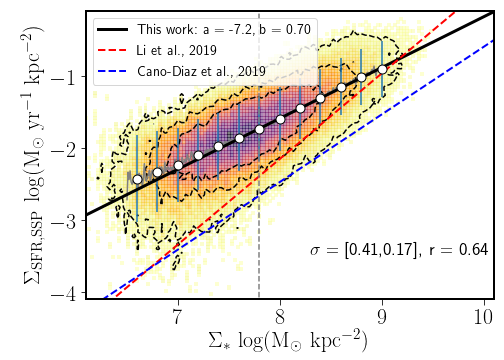

In [187]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

tmp_x  = np.linspace(0.0+6,5+6,1000)

im = host.hist2d(np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_SFR_sel*1e6), 
            cmin =10, bins = 200, cmap = 'inferno_r', alpha = 0.5)

mylevels = [0.05, 0.20, 0.40]
host.contour(counts.transpose(), mylevels, 
             extent=(np.nanmin(x_plt),np.nanmax(x_plt),np.nanmin(y_plt),np.nanmax(y_plt)),
             linestyles='dashed', colors = 'k')

host.errorbar(xW_SFMS,yWM_SFMS, yerr = yWS_SFMS, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(xN_SFMS, yNM_SFMS, '0.5', markersize = 9)

funct3 = lambda x,a,b: a + b*x
val3 = [np.log10(8.0*10e31*1e-42)-1.0, 1.005]
val4 = [-11.68, 1.19]
val5 = [-10.0, 0.94]

host.plot(tmp_x, res_rSFMS_binW[1]+res_rSFMS_binW[0]*tmp_x,
          ls = '-', c = 'k', linewidth = 3.0, label = 'This work: a = -7.2, b = 0.70') 
host.plot(tmp_x, funct3(tmp_x, val4[0], val4[1]) , 
          linestyle='dashed',color = 'red',lw =2, label = 'Li et al., 2019')
host.plot(tmp_x, funct3(tmp_x, val5[0], val5[1]) , 
          linestyle='dashed',color = 'blue',lw =2, label = 'Cano-Diaz et al., 2019')

sctr_rSFMS_Psien = np.log10(Sigma_SFR_sel*1e6) - funct3(np.log10(Sigma_Str_sel*1e6), val3[0], val3[1])

host.plot([ limit_Sstar,  limit_Sstar],[-6,1], linestyle='dashed',color = '0.5')

host.set_ylabel('$\Sigma_\mathrm{SFR,SSP}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{\\ast}}$ $\log(\mathrm{M_{\odot}\,\,kpc^{-2}})$', fontsize= 22)

plt.legend(loc =2, fontsize = 14, ncol = 1)
plt.annotate('$\\sigma=$ [0.41,0.17], r = 0.64',xy=(8.3,-3.5), fontsize = 18)

host.set_ylim([-4.1,-0.1])
host.set_xlim([ 6.1,10.1])

plt.savefig('plots/rSFMS_SSP_MPL9.pdf')
plt.savefig('plots/rSFMS_SSP_MPL9.png')

## Residuals of the rSFMS w.r.t Sigma_stellar

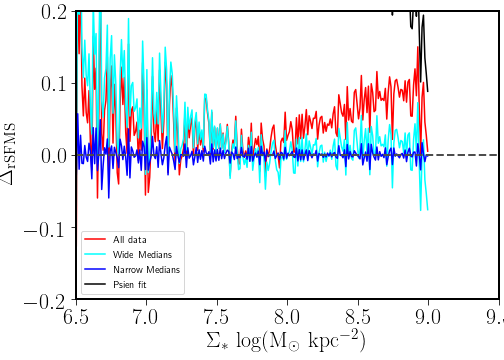

In [61]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN1,yNM1,yNS1 = med(np.log10(Sigma_Str_sel*1e6),sctr_rSFMS_all,paramN_rSFMS)
xN2,yNM2,yNS2 = med(np.log10(Sigma_Str_sel*1e6),sctr_rSFMS_bin,paramN_rSFMS)
xN3,yNM3,yNS3 = med(x1a,sctr_rSFMS_in,paramN_rSFMS)
xN4,yNM4,yNS4 = med(np.log10(Sigma_Str_sel*1e6),sctr_rSFMS_Psien,paramN_rSFMS)


host.plot(xN1, yNM1, 'red'  , markersize = 8, label = 'All data       ')
host.plot(xN2, yNM2, 'cyan' , markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue' , markersize = 8, label = 'Narrow Medians ')
host.plot(xN4, yNM4, 'black', markersize = 8, label = 'Psien fit ')
# host.hist2d(x1a,sctr_rSFMS_in,cmin =10, bins = 200, cmap = 'inferno_r', alpha = 0.5)

host.plot([6.5, 9.5], [0.0, 0.0], '0.3', linewidth =2,linestyle = '--')

host.set_ylim([-0.2, 0.2])
host.set_xlim([ 6.5, 9.5])

host.set_ylabel('$\\Delta_\mathrm{rSFMS}$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{*}}$ $\log(\mathrm{M_{\odot}\,\,kpc^{-2}})$', fontsize= 22)
host.legend()

## Standard Deviation of the residuals 

In [62]:
print('##################' )
print('#####  SFMS ######' )
print('##################' )
print ('Std, variance  all the sample:',   np.std(sctr_rSFMS_all), np.var(sctr_rSFMS_all))
print ('Std, variance  wide bins     :',   np.std(sctr_rSFMS_bin), np.var(sctr_rSFMS_bin))
print ('Std, variance  narrow bins   :',   np.nanstd(sctr_rSFMS_in), np.nanvar(sctr_rSFMS_in))
print('------------------------------------')
limit_Sstar1 = np.log10(Sigma_Str_sel*1e6) > limit_Sstar
lim_x1a      = x1a > limit_Sstar
print ('Std, variance  all the sample wCUT:',   np.std(sctr_rSFMS_all[limit_Sstar1]), np.var(sctr_rSFMS_all[limit_Sstar1]))
print ('Std, variance  wide bins      wCUT:',   np.std(sctr_rSFMS_bin[limit_Sstar1]), np.var(sctr_rSFMS_bin[limit_Sstar1]))
print ('Std, variance  narrow bins    wCUT:',   np.nanstd(sctr_rSFMS_in[lim_x1a]), np.nanvar(sctr_rSFMS_in[lim_x1a]))


##################
#####  SFMS ######
##################
Std, variance  all the sample: 0.4775524093210204 0.22805630364831142
Std, variance  wide bins     : 0.4787614537997131 0.22921252964441483
Std, variance  narrow bins   : 0.4644589771921026 0.2157221414943341
------------------------------------
Std, variance  all the sample wCUT: 0.4205539984689402 0.17686566562821335
Std, variance  wide bins      wCUT: 0.41945341301885297 0.17594116569316445
Std, variance  narrow bins    wCUT: 0.4205767077732084 0.17688476712135073


# ============ Minimization x= S_gas, KS Law =================

In [64]:
# Select 80% sample
#x2_sel,y2_sel, index2_sel, contour2_sel = sel2dContour_Open(np.log10(Sigma_Gas_sel), 
#                                                            np.log10(Sigma_SFR_sel*1e6),
#                                                            ld = True )

In [189]:
paramW_rKSL = [0.1, 0.5+6, 1.5+6]
#xW,yWM,yWS   = med(x2_sel,y2_sel,paramW_rKSL)
xW_KSL,yWM_KSL,yWS_KSL   = med(np.log10(Sigma_Gas_sel*1e6), np.log10(Sigma_SFR_sel*1e6), paramW_rKSL)
paramN_rKSL = [0.01, 0.5+6, 1.5+6]
#xN,yNM,yNS   = med(x2_sel,y2_sel,paramN_rKSL)
xN_KSL,yNM_KSL,yNS_KSL   = med(np.log10(Sigma_Gas_sel*1e6), np.log10(Sigma_SFR_sel*1e6), paramN_rKSL)

In [190]:
#path_90, path_80, path_60 = contour2_sel.collections[0].get_paths()[0],\
#contour2_sel.collections[1].get_paths()[0], contour2_sel.collections[2].get_paths()[0]
#cont_90, cont_80, cont_60 = path_90.vertices, path_80.vertices, path_60.vertices

In [191]:
x0_rKSL  = [1.,1.]
res_rKSL , flag_rKSL  = optimize.leastsq(fun_lin, x0_rKSL , 
                           args = (np.log10(Sigma_Gas_sel*1e6), 
                                    np.log10(Sigma_SFR_sel*1e6)))

print('BEST FIT rKSL (All data): ',res_rKSL, flag_rKSL)


x0_rKSL = [1.,1.]
sel2fit  = xW_KSL > 0.9+6
res_rKSL_binW, flag_rKSL_binW = optimize.leastsq(fun_lin, x0_rKSL, 
                           args = (xW_KSL[sel2fit],yWM_KSL[sel2fit]))

print('BEST FIT rKSL (BINS): ',res_rKSL_binW, flag_rKSL_binW)

sctr_rKSL_all = np.log10(Sigma_SFR_sel*1e6) -  (res_rKSL[1]+res_rKSL[0]*(np.log10(Sigma_Gas_sel*1e6)))
sctr_rKSL_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_rKSL_binW[1]+res_rKSL_binW[0]*(np.log10(Sigma_Gas_sel*1e6)))

# Scatter from narrow medians
idx_tt  = (np.log10(Sigma_Gas_sel*1e6) > paramN_rKSL[1]) & (np.log10(Sigma_Gas_sel*1e6) < paramN_rKSL[2])
x1a,y1a = np.log10(Sigma_Gas_sel[idx_tt]),np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1 = interp(xN_KSL, yNM_KSL, x1a)

sctr_rKSL_in = y1a- yinter1

BEST FIT rKSL (All data):  [ 0.40928165 -4.74515479] 3
BEST FIT rKSL (BINS):  [ 0.75390375 -7.18790606] 1


In [192]:
x_plt, y_plt = np.log10(Sigma_Gas_sel*1e6), np.log10(Sigma_SFR_sel*1e6)
counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=150,
                                      normed=True,
                                      range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
counts /= counts.max()

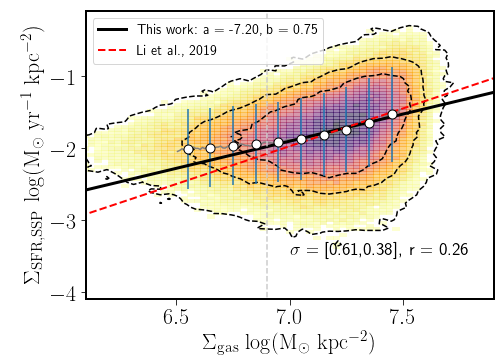

In [193]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

tmp_x  = np.linspace(-0.4+6,5.0+6,1000)


im = host.hist2d(np.log10(Sigma_Gas_sel*1e6), np.log10(Sigma_SFR_sel*1e6), 
            cmin =30, bins = 200, cmap = 'inferno_r', alpha = 0.5)

mylevels = [0.05, 0.20, 0.40]
host.contour(counts.transpose(), mylevels, 
             extent=(np.nanmin(x_plt),np.nanmax(x_plt),np.nanmin(y_plt),np.nanmax(y_plt)),
             linestyles='dashed', colors = 'k')

host.errorbar(xW_KSL,yWM_KSL, yerr = yWS_KSL, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(xN_KSL, yNM_KSL, '0.5', markersize = 9)

host.plot(tmp_x, res_rKSL_binW[1]+res_rKSL_binW[0]*tmp_x,
          ls = '-', c = 'k', linewidth = 3.0, label = 'This work: a = -7.20, b = 0.75') 
host.plot(tmp_x, funct3(tmp_x, -9.33, 1.05), 
          linestyle='dashed',color = 'red',lw =2, label = 'Li et al., 2019')


host.plot([ 0.9+6,  0.9+6],[-6,1], linestyle='dashed',color = '0.8')
host.set_ylim([-4.1,-0.1])
host.set_xlim([ 0.1+6, 1.9+6])
host.set_ylabel('$\Sigma_\mathrm{SFR,SSP}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{gas}}$ $\log(\mathrm{M_{\odot}\,\,kpc^{-2}})$', fontsize= 22)
plt.legend(loc = 2, fontsize = 14)
plt.annotate('$\\sigma=$ [0.61,0.38], r = 0.26',xy=(7.0,-3.5), fontsize = 18)

# plt.savefig('plots/rKS_SSP_MPL9.pdf')
# plt.savefig('plots/rKS_SSP_MPL9.png')

## Residuals of the rKSL w.r.t Sigma_gas

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


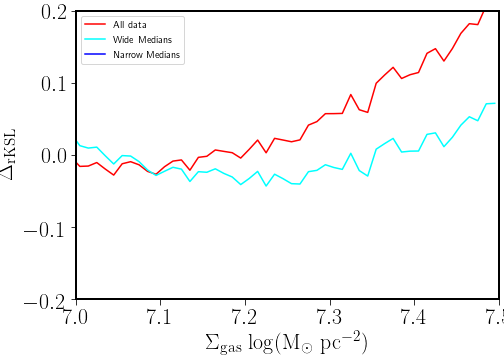

In [74]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN1,yNM1,yNS1 = med(np.log10(Sigma_Gas_sel*1e6),sctr_rKSL_all,paramN_rKSL)
xN2,yNM2,yNS2 = med(np.log10(Sigma_Gas_sel*1e6),sctr_rKSL_bin,paramN_rKSL)
xN3,yNM3,yNS3 = med(x1a,sctr_rKSL_in,paramN_rKSL)


host.plot(xN1, yNM1, 'red', markersize = 8,  label = 'All data       ')
host.plot(xN2, yNM2, 'cyan', markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue', markersize = 8, label = 'Narrow Medians ')
host.plot([1.0, 1.5], [0.0, 0.0], '0.3', linewidth =2,linestyle = '--')

host.set_ylim([-0.2, 0.2])
host.set_xlim([ 1.0+6, 1.5+6])

host.set_ylabel('$\\Delta_\mathrm{rKSL}$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{gas}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)
host.legend()

## Standard Deviation of the residuals 

In [75]:
print('##################' )
print('#####  KSL  ######' )
print('##################' )
print ('Std, variance  all the sample', np.std(sctr_rKSL_all),  np.var(sctr_rKSL_all))
print ('Std, variance  wide bins     ', np.std(sctr_rKSL_bin),   np.var(sctr_rKSL_bin))
print ('Std, variance  narrow bins   ', np.nanstd(sctr_rKSL_in), np.nanvar(sctr_rKSL_in))

##################
#####  KSL  ######
##################
Std, variance  all the sample 0.6019217154512887 0.36230975153182216
Std, variance  wide bins      0.6177108154951338 0.38156665157966324
Std, variance  narrow bins    0.6009844148842137 0.36118226693372074


# =========  MGMS ===========

Text(0.5, 0, '$\\mathrm{\\Sigma_{*}}$ $\\log(\\mathrm{M_{\\odot}\\,\\,kpc^{-2}})$')

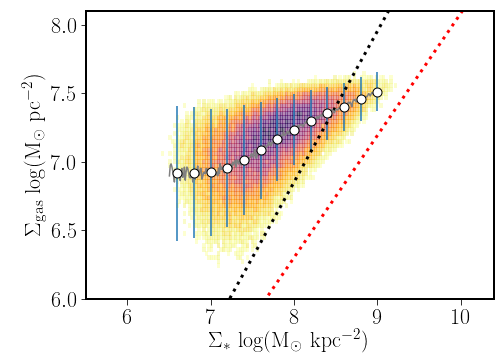

In [77]:
paramW_rSFMS = [0.2, 6.5, 9.0]
#xW,yWM,yWS   = med(x1_sel,y1_sel,paramW_rSFMS)
xW_MGMS,yWM_MGMS,yWS_MGMS   = med(np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_Gas_sel*1e6),paramW_rSFMS)

paramN_rSFMS = [0.01, 6.5, 9.0]
#xN,yNM,yNS   = med(x1_sel,y1_sel,paramN_rSFMS)
xN_MGMS,yNM_MGMS,yNS_MGMS   = med(np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_Gas_sel*1e6),paramN_rSFMS)


fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

tmp_x  = np.linspace(0.4+6,5.0+6,1000)


im = host.hist2d(np.log10(Sigma_Str_sel*1e6), np.log10(Sigma_Gas_sel*1e6), 
            cmin =40, bins = 200, cmap = 'inferno_r', alpha = 0.5)

host.errorbar(xW_MGMS,yWM_MGMS, yerr = yWS_MGMS, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(tmp_x, funct3(tmp_x, -1.95, 1.10) , 
          linestyle='dotted',color = 'k',lw =3, label = 'Li et al., 2019 (MaNGA)')

host.plot(tmp_x, funct3(tmp_x, -0.82, 0.89) , 
          linestyle='dotted',color = 'r',lw =3, label = 'Li et al., 2019 (MaNGA)')

host.plot(xN_MGMS, yNM_MGMS, '0.5', markersize = 9)



host.set_ylim([ 6.0, 8.1])
host.set_xlim([ 5.5, 10.4])
host.set_ylabel('$\mathrm{\\Sigma_{gas}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)
host.set_xlabel('$\mathrm{\\Sigma_{*}}$ $\log(\mathrm{M_{\odot}\,\,kpc^{-2}})$', fontsize= 22)



# ============ Minimization x= S_gas+S_star , Sb =================

In [194]:
Sb = (Sigma_Gas_sel+Sigma_Str_sel)*1e6

In [195]:
paramW_Sb = [0.2, 6.9, 9.1]
xW_Sb,yWM_Sb,yWS_Sb   = med(np.log10(Sb), np.log10(Sigma_SFR_sel*1e6), paramW_Sb)

paramN_Sb = [0.02, 6.9, 9.1]
xN_Sb,yNM_Sb,yNS_Sb   = med(np.log10(Sb), np.log10(Sigma_SFR_sel*1e6), paramN_Sb)

In [196]:
x0_rSb  = [1.,1.]
res_rSb , flag_rSb  = optimize.leastsq(fun_lin, x0_rSb , 
                           args = (np.log10(Sb), 
                                    np.log10(Sigma_SFR_sel*1e6)))

print('BEST FIT  (All data): ',res_rSb , flag_rSb)

x0_rKSL = [1.,1.]
sel2fit  = xW_Sb > 7.9
res_rSb_binW , flag_rSb_binW = optimize.leastsq(fun_lin, x0_rSb, 
                           args = (xW_Sb[sel2fit],yWM_Sb[sel2fit]))

print('BEST FIT (BINS): ', res_rSb_binW , flag_rSb_binW)

BEST FIT  (All data):  [ 0.76854376 -7.85157933] 3
BEST FIT (BINS):  [ 0.75550411 -7.69860471] 3


In [197]:
x_plt, y_plt = np.log10(Sb), np.log10(Sigma_SFR_sel*1e6)
counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=150,
                                      normed=True,
                                      range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
counts /= counts.max()

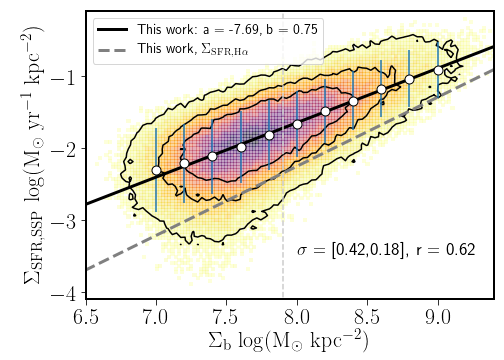

In [198]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

tmp_x  = np.linspace(-1.0+6,5.0+6,1000)


im = host.hist2d(np.log10(Sb), np.log10(Sigma_SFR_sel*1e6), 
            cmin =10, bins = 200, cmap = 'inferno_r', alpha = 0.4)

mylevels = [0.05, 0.20, 0.40]
host.contour(counts.transpose(), mylevels, 
             extent=(np.nanmin(x_plt),np.nanmax(x_plt),np.nanmin(y_plt),np.nanmax(y_plt)),
             linestyles='solid', colors = 'k')

host.errorbar(xW_Sb,yWM_Sb, yerr = yWS_Sb, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(tmp_x, res_rSb_binW[1]+res_rSb_binW[0]*tmp_x,
          ls = '-', c = 'k', linewidth = 3.0, label = 'This work: a = -7.69, b = 0.75') 

host.plot(tmp_x, funct3(tmp_x, -9.94, 0.96) , 
          linestyle='dashed',color = '0.5',lw =3, label = 'This work, $\Sigma_\mathrm{SFR,H\\alpha}$')

host.plot([ 7.9,  7.9],[-6,1], linestyle='dashed',color = '0.8')

host.set_ylim([-4.1,-0.1])
host.set_xlim([ 6.5, 9.4])

plt.annotate('$\\sigma=$ [0.42,0.18], r = 0.62',xy=(8.0,-3.5), fontsize = 18)
plt.legend(loc = 2, fontsize = 14)

host.set_ylabel('$\Sigma_\mathrm{SFR,SSP}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{b}}$ $\log(\mathrm{M_{\odot}\,\,kpc^{-2}})$', fontsize= 22)
# plt.savefig('plots/rSFBS_SSP_MPL9.pdf')
# plt.savefig('plots/rSFBS_SSP_MPL9.png')

In [103]:
sctr_Sb_all = np.log10(Sigma_SFR_sel*1e6) -  (res_rSb[1]+res_rSb[0]*(np.log10(Sb)))
sctr_Sb_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_rSb_binW[1]+res_rSb_binW[0]*(np.log10(Sb)))

# Scatter from narrow medians
idx_tt  = (np.log10(Sb) > paramN_Sb[1]) & (np.log10(Sb) < paramN_Sb[2])
x1a_Sb,y1a_Sb = np.log10(Sb[idx_tt]),np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1_Sb = interp(xN_Sb, yNM_Sb, x1a_Sb)

sctr_Sb_in = y1a_Sb- yinter1_Sb

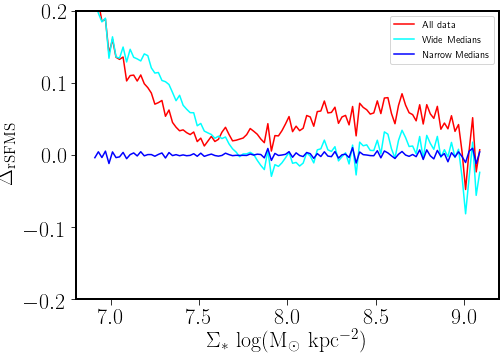

In [104]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN1,yNM1,yNS1 = med(np.log10(Sb),sctr_Sb_all,paramN_Sb)
xN2,yNM2,yNS2 = med(np.log10(Sb),sctr_rSFMS_bin,paramN_Sb)
xN3,yNM3,yNS3 = med(x1a_Sb,sctr_Sb_in,paramN_Sb)


host.plot(xN1, yNM1, 'red'  , markersize = 8, label = 'All data       ')
host.plot(xN2, yNM2, 'cyan' , markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue' , markersize = 8, label = 'Narrow Medians ')

host.set_ylim([-0.2, 0.2])
# host.set_xlim([ 6.5, 9.5])

host.set_ylabel('$\\Delta_\mathrm{rSFMS}$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{*}}$ $\log(\mathrm{M_{\odot}\,\,kpc^{-2}})$', fontsize= 22)
host.legend()

In [105]:
print('##################' )
print('#####  Sb ######' )
print('##################' )
print ('Std, variance  all the sample:',   np.std(sctr_Sb_all), np.var(sctr_Sb_all))
print ('Std, variance  wide bins     :',   np.std(sctr_Sb_bin), np.var(sctr_Sb_bin))
print ('Std, variance  narrow bins   :',   np.nanstd(sctr_Sb_in), np.nanvar(sctr_Sb_in))
print('------------------------------------')
limit_Sstar1 = np.log10(Sb) > 7.9
lim_x1a      = x1a_Sb > 7.9
print ('Std, variance  all the sample wCUT:',   np.std(sctr_Sb_all[limit_Sstar1]), np.var(sctr_Sb_all[limit_Sstar1]))
print ('Std, variance  wide bins      wCUT:',   np.std(sctr_Sb_bin[limit_Sstar1]), np.var(sctr_Sb_bin[limit_Sstar1]))
print ('Std, variance  narrow bins    wCUT:',   np.nanstd(sctr_Sb_in[lim_x1a]), np.nanvar(sctr_Sb_in[lim_x1a]))

##################
#####  Sb ######
##################
Std, variance  all the sample: 0.4879757510418882 0.23812033360489482
Std, variance  wide bins     : 0.48802039161703265 0.23816390263404189
Std, variance  narrow bins   : 0.4832408524598715 0.23352172148614325
------------------------------------
Std, variance  all the sample wCUT: 0.4283141027011829 0.18345297057271945
Std, variance  wide bins      wCUT: 0.4284637883747272 0.18358121794842303
Std, variance  narrow bins    wCUT: 0.429240867216681 0.18424772208892837


# ========================================================

/anaconda3/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:323: RuntimeWarning: divide by zero encountered in true_divide
  result[a] /= flatcount
/anaconda3/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:323: RuntimeWarning: invalid value encountered in true_divide
  result[a] /= flatcount


Text(0.5, 0, '$\\mathrm{\\Sigma_{b}}$ $\\log(\\mathrm{M_{\\odot}\\,\\,kpc^{-2}})$')

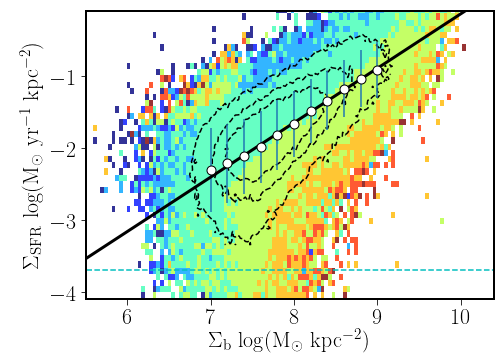

In [106]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

ew_mean1, xedges1, yedges1 = binned_statistic_2d(np.log10(Sb), np.log10(Sigma_SFR_sel*1e6), 
                                        np.log10(np.abs(EW[idx_SF][idx1])),
                                        'mean', bins=100)

im = plt.imshow(ew_mean1.T, origin='lower',
           extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]],
           aspect='auto', interpolation='nearest', alpha = 0.8,
           cmap=plt.cm.get_cmap('jet_r', 8),vmin = 1.0, vmax = 2.4)

host.contour(counts.transpose(), mylevels, 
             extent=(np.nanmin(x_plt),np.nanmax(x_plt),np.nanmin(y_plt),np.nanmax(y_plt)),
             linestyles='dashed', colors = 'k')

host.errorbar(xW_Sb,yWM_Sb, yerr = yWS_Sb, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(tmp_x, res_rSb_binW[1]+res_rSb_binW[0]*tmp_x,ls = '-', c = 'k', linewidth = 3.0) 

host.plot([-6,16],[-3.7, -3.7],'--c')
host.plot([-2.1,-2.1],[-4.7, 1.7],'--c')

host.set_ylim([-4.1,-0.1])
host.set_xlim([ 5.5, 10.4])

host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{b}}$ $\log(\mathrm{M_{\odot}\,\,kpc^{-2}})$', fontsize= 22)

In [199]:
##################################################################
# Model function of x-axis with two parameters
def model_lin_2par(params, x):
    a,c = params
    y = a*x[0]+ c*x[0]**2 #+ d*x[1]**2 
#     y = a*x[0]+ c*x[1] #+ d*x[1]**2 
#     y = a*x[0]+ b*x[0]**2 + c*x[1] #+ d*x[1]**2   
#     b,c = params
#     y = x[0] + b*x[1] + c*x[1]**2
    return y

# Function to minimize for model_2par
def fun_lin_2par(params, x, y_data):
    return y_data - model_lin_2par(params, x)



In [200]:
x0 = [1,1]
# res_SbEW, flag_SbEW = optimize.leastsq(fun_lin_2par, x0, 
#                            args = ([np.log10(Sb),
#                                     np.log10(np.abs(EW[idx_SF][idx1]))],
#                                     np.log10(Sigma_SFR_sel*1e6)))

res_SbEW, flag_SbEW = optimize.leastsq(fun_lin_2par, x0, 
                           args = ([np.log10(Sb)],
                                    np.log10(Sigma_SFR_sel*1e6)))



# sSFR = np.log10(Sigma_SFR_sel*1e6) - np.log10(Sigma_Str_sel*1e6)
# res_SbEW, flag_SbEW = optimize.leastsq(fun_lin_2par, x0, 
#                            args = ([np.log10(Sb),
#                                     sSFR],
#                                     np.log10(Sigma_SFR_sel*1e6)))

sel2fit = np.log10(Sigma_Str_sel*1e6) > 7.5
res_SbEW_sel, flag_SbEW_sel = optimize.leastsq(fun_lin_2par, x0, 
                            args = ([np.log10(Sb[sel2fit]), 
                                     np.log10(np.abs(EW[idx_SF][idx1][sel2fit]))], 
                                     np.log10(Sigma_SFR_sel[sel2fit]*1e6)))
print(res_SbEW, flag_SbEW)
print(res_SbEW_sel, flag_SbEW_sel)

[-1.22055075  0.12543379] 3
[-1.12393932  0.11403612] 2


In [201]:
# SbEW = model_lin_2par(res_SbEW,[np.log10(Sb), np.log10(np.abs(EW[idx_SF][idx1]))])
# SbEW = model_lin_2par(res_SbEW,[np.log10(Sb), sSFR] )
SbEW = model_lin_2par(res_SbEW,[np.log10(Sb)])

In [202]:
paramW_SbEW = [0.2, -2.4, -0.8]
xW_SbEW,yWM_SbEW,yWS_SbEW   = med(SbEW, np.log10(Sigma_SFR_sel*1e6), paramW_SbEW)

paramN_SbEW = [0.02, -2.4, -0.8]
xN_SbEW,yNM_SbEW,yNS_SbEW   = med(SbEW, np.log10(Sigma_SFR_sel*1e6), paramN_SbEW)

In [203]:
res_rSbEW_binW , flag_rSbEW_binW = optimize.leastsq(fun_lin, x0_rSb, 
                           args = (xW_SbEW,yWM_SbEW))

print('BEST FIT (BINS): ', res_rSbEW_binW , flag_rSbEW_binW)

BEST FIT (BINS):  [ 0.930933   -0.07446921] 2


In [204]:
x_plt, y_plt = SbEW, np.log10(Sigma_SFR_sel*1e6)
counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=150,
                                      normed=True,
                                      range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
counts /= counts.max()

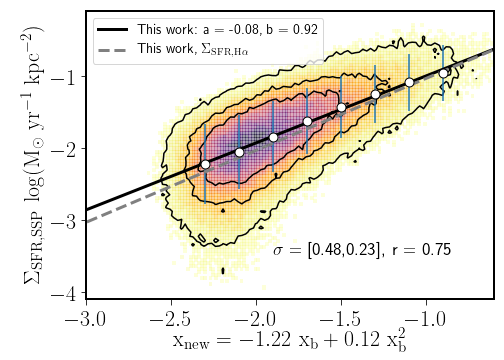

In [210]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

im = host.hist2d(SbEW, np.log10(Sigma_SFR_sel*1e6), 
            cmin =10, bins = 200, cmap = 'inferno_r', alpha = 0.4)

host.contour(counts.transpose(), mylevels, 
             extent=(np.nanmin(x_plt),np.nanmax(x_plt),np.nanmin(y_plt),np.nanmax(y_plt)),
             linestyles='solid', colors = 'k')

host.errorbar(xW_SbEW,yWM_SbEW, yerr = yWS_SbEW, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

tmp_x  = np.linspace(0.0-6,7.0-6,1000)
host.plot(tmp_x, res_rSbEW_binW[1]+res_rSbEW_binW[0]*tmp_x,
          ls = '-', c = 'k', linewidth = 3.0, label = 'This work: a = -0.08, b = 0.92') 
host.plot(tmp_x, funct3(tmp_x, -0.04, 1.0) , 
          linestyle='dashed',color = '0.5',lw =3, label = 'This work, $\Sigma_\mathrm{SFR,H\\alpha}$')

host.set_ylim([-4.1,-0.1])
host.set_xlim([-3.0,-0.6])

plt.annotate('$\\sigma=$ [0.48,0.23], r = 0.75',xy=(-1.9,-3.5), fontsize = 18)
host.set_ylabel('$\Sigma_\mathrm{SFR,SSP}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_xlabel('$\mathrm{x_{new} = -1.22\,\,x_{b}+0.12\,\,x_{b}^{2}}$', fontsize= 22)
plt.legend(loc = 2, fontsize = 14)

# plt.savefig('plots/rSF_Sbfit_SSP.pdf')
# plt.savefig('plots/rSF_Sbfit_SSP.png')

In [131]:
sctr_SbEW_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_rSbEW_binW[1]+ res_rSbEW_binW[0]*(SbEW))

# Scatter from narrow medians
idx_tt  = (SbEW > paramN_SbEW[1]) & (SbEW < paramN_SbEW[2])
x1a_SbEW,y1a_SbEW = SbEW[idx_tt], np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1_SbEW = interp(xN_SbEW, yNM_SbEW, x1a_SbEW)

sctr_SbEW_in = y1a_SbEW- yinter1_SbEW
print(sctr_SbEW_in)

[-0.04661223 -0.56214725  0.14459402 ... -0.30133733 -0.18443697
 -0.135695  ]


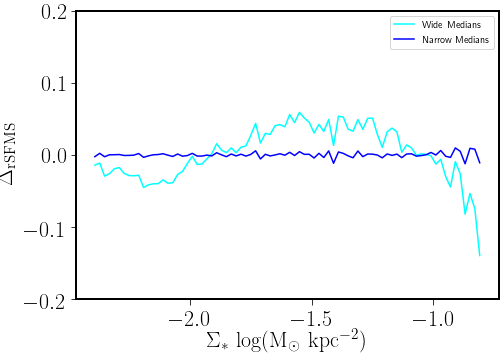

In [132]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN2,yNM2,yNS2 = med(SbEW,sctr_SbEW_bin,paramN_SbEW)
xN3,yNM3,yNS3 = med(x1a_SbEW,sctr_SbEW_in,paramN_SbEW)


#host.plot(xN1, yNM1, 'red'  , markersize = 8, label = 'All data       ')
host.plot(xN2, yNM2, 'cyan' , markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue' , markersize = 8, label = 'Narrow Medians ')

host.set_ylim([-0.2, 0.2])
# host.set_xlim([ 6.5, 9.5])

host.set_ylabel('$\\Delta_\mathrm{rSFMS}$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{*}}$ $\log(\mathrm{M_{\odot}\,\,kpc^{-2}})$', fontsize= 22)
host.legend()

In [133]:
print('##################' )
print('#####  SbEW ######' )
print('##################' )
# print ('Std, variance  all the sample:',   np.std(sctr_Sb_all), np.var(sctr_Sb_all))
print ('Std, variance  wide bins     :',   np.std(sctr_SbEW_bin), np.var(sctr_SbEW_bin))
print ('Std, variance  narrow bins   :',   np.nanstd(sctr_SbEW_in), np.nanvar(sctr_SbEW_in))



##################
#####  SbEW ######
##################
Std, variance  wide bins     : 0.4878316089337223 0.23797967867486414
Std, variance  narrow bins   : 0.4818555506138521 0.23218477165737858


# ============ Minimization x= EW, XXX =================

In [ ]:
# # Select 80% sample
# x3_sel,y3_sel, index3_sel, contour3_sel = sel2dContour_Open(np.log10(np.abs(EW[idx_SF][idx1])), 
#                                                             np.log10(Sigma_SFR_sel*1e6),
#                                                             ld = True )

In [ ]:
# paramW_rEW = [0.1, 0.9, 1.8]
# xW,yWM,yWS   = med(x3_sel,y3_sel,paramW_rEW)

# paramN_rEW = [0.01, 0.9, 1.8]
# xN,yNM,yNS   = med(x3_sel,y3_sel,paramN_rEW)

In [ ]:
# path_90, path_80, path_60 = contour3_sel.collections[0].get_paths()[0],\
# contour3_sel.collections[1].get_paths()[0], contour3_sel.collections[2].get_paths()[0]
# cont_90, cont_80, cont_60 = path_90.vertices, path_80.vertices, path_60.vertices

In [ ]:
# x0_rEW = [1.,1.]
# res_rEW  , flag_rEW   = optimize.leastsq(fun_lin, x0_rEW , 
#                            args = (np.log10(np.abs(EW[idx_SF][idx1])), 
#                                     np.log10(Sigma_SFR_sel*1e6)))

# print('BEST FIT rEW (All data): ',res_rEW, flag_rEW)

# x0_rKSL = [1.,-3.]
# res_rEW_binW, flag_rEW_binW = optimize.leastsq(fun_lin, x0_rKSL, 
#                            args = (xW,yWM))

# print('BEST FIT rEW (BINS): ',res_rEW_binW, flag_rEW_binW)

# sctr_rEW_all = np.log10(Sigma_SFR_sel*1e6) -  (res_rEW[1]+res_rEW[0]*np.log10(np.abs(EW[idx_SF][idx1])))
# sctr_rEW_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_rEW_binW[1]+res_rEW_binW[0]*np.log10(np.abs(EW[idx_SF][idx1])))

# # Scatter from narrow medians
# idx_tt  = (np.log10(np.abs(EW[idx_SF][idx1])) > paramN_rEW[1]) & (np.log10(np.abs(EW[idx_SF][idx1])) < paramN_rEW[2])
# x1a,y1a = np.log10(Sigma_Gas_sel[idx_tt]),np.log10(np.abs(EW[idx_SF][idx1][idx_tt]))
# yinter1 = interp(xN, yNM, x1a)

# sctr_rEW_in = y1a- yinter1

In [ ]:
# fig = plt.figure(figsize=(7.0,5.0))
# width, hight = 0.81, 0.80
# host  = plt.axes([0.17, 0.17, width, hight])

# tmp_x  = np.linspace(0.2,5.0,1000)

# im = host.hist2d(np.log10(np.abs(EW[idx_SF][idx1])), np.log10(Sigma_SFR_sel*1e6), 
#             cmin =20, bins = 200, cmap = 'inferno_r', alpha = 0.5)

# host.errorbar(xW,yWM, yerr = yWS, 
#               markerfacecolor ='white', markeredgecolor = 'black', 
#               fmt = 'o', markersize = 9)

# host.plot(xN, yNM, '0.5', markersize = 9)

# host.plot(tmp_x, res_rEW_binW[1]+res_rEW_binW[0]*tmp_x,ls = '--', c = 'blue', linewidth = 3.0) 
# #host.plot(tmp_x, res_rKSL_binW[1]+res_rKSL_binW[0]*tmp_x,ls = '--', c = 'red', linewidth = 3.0) 

# host.plot((cont_60[:,0]),cont_60[:,1],'--b')
# host.plot((cont_80[:,0]),cont_80[:,1],'--b')
# host.plot((cont_90[:,0]),cont_90[:,1],'--b')



# host.set_ylim([-3.7,-0.5])
# host.set_xlim([ 0.5, 2.2])

In [ ]:
# print ('Standard deviation of the scatter using all the sample', np.std(sctr_rEW_all))

# ======== Minimization of x =f(S_stelar,S_gas) , fun_2par ==========

## Creating the X-AXIS 

In [147]:
# fitting using leastsq function
x0 = [1.,1.,1.,1.]

sel2fitW = (xW_SFMS > 7.9)
sel2fitN = (xN_SFMS > 7.9)

sel2fit = (Sigma_Str_sel*1e6 > 7.8)
res, flag = optimize.leastsq(fun_2par, x0, 
                           args = ([np.log10(Sigma_Str_sel_cgs[sel2fit]), 
                                    np.log10(Sigma_Gas_sel_cgs[sel2fit])], 
                                   np.log10(Sigma_SFR_sel[sel2fit]*1e6)))

resW, flagW = optimize.leastsq(fun_2par, x0, 
                           args = ([xW_SFMS[sel2fitW]-6-np.log10(2.21e-4), yWM_MGMS[sel2fitW]-6-np.log10(2.21e-4)], yWM_SFMS[sel2fitW]))

resN, flagN = optimize.leastsq(fun_2par, x0, 
                           args = ([xN_SFMS[sel2fitN]-6-np.log10(2.21e-4), yNM_MGMS[sel2fitN]-6-np.log10(2.21e-4)], yNM_SFMS[sel2fitN]))
print(res , flag )
print(resW, flagW)
print(resN, flagN)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in power


[ 0.02507662 -0.53764118  0.00064321  0.62410393] 1
[ 0.30007456 -0.42038326  0.22457979  0.76514904] 1
[ 0.30250991 -0.4215926   0.10136734  0.78362167] 1


In [148]:
# X axis from fitting
x_bf  = model_2par(res ,[np.log10(Sigma_Str_sel_cgs), np.log10(Sigma_Gas_sel_cgs)])
x_bfW = model_2par(resW,[xW_SFMS[sel2fitW]-6-np.log10(2.21e-4), yWM_MGMS[sel2fitW]-6-np.log10(2.21e-4)])

In [149]:
paramW_bf = [0.2, -3.5, -0.5]
xW_bf,yWM_bf,yWS_bf   = med(x_bf, np.log10(Sigma_SFR_sel*1e6),paramW_bf)

paramN_bf = [0.02, -3.5, -0.5]
xN_bf,yNM_bf,yNS_bf   = med(x_bf, np.log10(Sigma_SFR_sel*1e6),paramN_bf)


In [150]:
x0_bf = [1.,1.]
res_bf_lin , flag_bf_lin  = optimize.leastsq(fun_lin, x0_bf , 
                           args = (x_bf, 
                                    np.log10(Sigma_SFR_sel*1e6)))
print('BEST FIT  (All data): ',res_bf_lin , flag_bf_lin)


selfit = (xW_bf > -1.75)
res_bf_lin_binW, flag_bf_lin_binW = optimize.leastsq(fun_lin, x0_rKSL, 
                           args = (xW_bf[selfit],yWM_bf[selfit]))
print('BEST FIT (BINS): ',res_bf_lin_binW, flag_bf_lin_binW)

BEST FIT  (All data):  [ 0.52443413 -0.92916743] 3
BEST FIT (BINS):  [ 0.77702879 -0.58423568] 3


In [151]:
x_plt, y_plt = x_bf, np.log10(Sigma_SFR_sel*1e6)
counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=150,
                                      normed=True,
                                      range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
counts /= counts.max()

Text(0.5, 0, '$\\mathrm{x_{bf}}$ $\\log(\\mathrm{M_{\\odot}\\,\\,pc^{-2}})$')

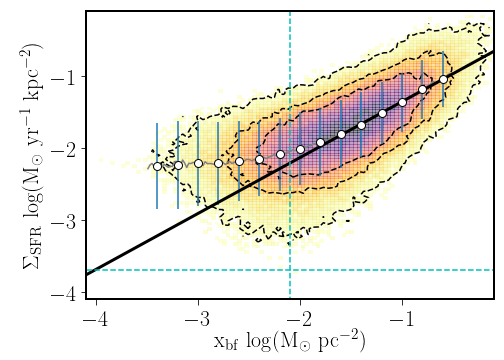

In [153]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

tmp_x  = np.linspace(-5,0.0,1000)

host.hist2d(x_plt, y_plt, 
            cmin =10, bins = 200, cmap = 'inferno_r', alpha = 0.4)

mylevels = [0.05, 0.20, 0.40]
host.contour(counts.transpose(), mylevels, 
             extent=(np.nanmin(x_plt),np.nanmax(x_plt),np.nanmin(y_plt),np.nanmax(y_plt)),
             linestyles='dashed', colors = 'k')

host.errorbar(xW_bf,yWM_bf, yerr = yWS_bf, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 8)

host.plot(xN_bf, yNM_bf, '0.5', markersize = 9)

host.plot(tmp_x, res_bf_lin_binW[1]+res_bf_lin_binW[0]*(tmp_x),ls = '-', c = 'black', linewidth = 3.0) 
#host.scatter(x_bfW, yWM_SFMS[sel2fitW])

host.plot([-6,6],[-3.7, -3.7],'--c')
host.plot([-2.1,-2.1],[-4.7, 1.7],'--c')

host.set_ylim([-4.1,-0.1])
host.set_xlim([-4.1,-0.1])

host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_xlabel('$\mathrm{x_{bf}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)

In [154]:
sctr_xBF_all = np.log10(Sigma_SFR_sel*1e6) -  (res_bf_lin[1]+res_bf_lin[0]*(x_bf))
sctr_xBF_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_bf_lin_binW[1]+res_bf_lin_binW[0]*(x_bf))

# Scatter from narrow medians
idx_tt  = (x_bf > paramN_bf[1]) & (x_bf < paramN_bf[2])
x1a_bf, y1a_bf = x_bf[idx_tt], np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1_bf = interp(xN_bf, yNM_bf, x1a_bf)
sctr_xBF_in = y1a_bf- yinter1_bf

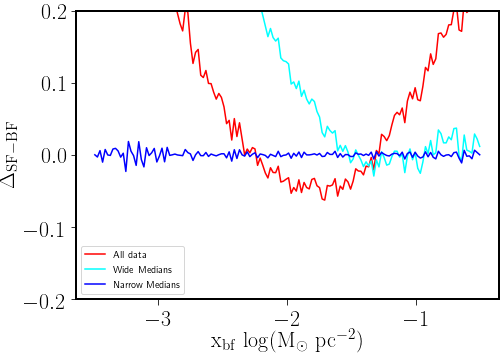

In [155]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN1,yNM1,yNS1 = med(x_bf,sctr_xBF_all,paramN_bf)
xN2,yNM2,yNS2 = med(x_bf,sctr_xBF_bin,paramN_bf)
xN3,yNM3,yNS3 = med(x1a_bf,sctr_xBF_in,paramN_bf)


host.plot(xN1, yNM1, 'red', markersize = 8,  label = 'All data       ')
host.plot(xN2, yNM2, 'cyan', markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue', markersize = 8, label = 'Narrow Medians ')
#host.plot([-13.0, -9.5], [0.0, 0.0], '0.3', linewidth =2,linestyle = '--')

host.set_ylim([-0.2, 0.2])
# host.set_xlim([ -11.7,-10.3])

host.set_ylabel('$\\Delta_\mathrm{SF-BF}$', fontsize = 22)
host.set_xlabel('$\mathrm{x_{bf}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)
host.legend()

In [156]:
print('##################' )
print('#####  X_BF ######' )
print('##################' )
print ('Std, variance  all the sample:',   np.std(sctr_xBF_all), np.var(sctr_xBF_all))
print ('Std, variance  wide bins     :',   np.std(sctr_xBF_bin), np.var(sctr_xBF_bin))
print ('Std, variance  narrow bins   :',   np.nanstd(sctr_xBF_in), np.nanvar(sctr_xBF_in))
print('------------------------------------')
limit_Sstar1 = x_bf > -1.95
lim_x1a      = x1a_bf > -1.95
print ('Std, variance  all the sample wCUT:',   np.std(sctr_xBF_all[limit_Sstar1]), np.var(sctr_xBF_all[limit_Sstar1]))
print ('Std, variance  wide bins      wCUT:',   np.std(sctr_xBF_bin[limit_Sstar1]), np.var(sctr_xBF_bin[limit_Sstar1]))
print ('Std, variance  narrow bins    wCUT:',   np.nanstd(sctr_xBF_in[lim_x1a]), np.nanvar(sctr_xBF_in[lim_x1a]))

##################
#####  X_BF ######
##################
Std, variance  all the sample: 0.49204037496227293 0.24210373059301415
Std, variance  wide bins     : 0.5205775866395114 0.271001023711418
Std, variance  narrow bins   : 0.4748504043271698 0.22548290648967662
------------------------------------
Std, variance  all the sample wCUT: 0.45532829408405234 0.20732385539349327
Std, variance  wide bins      wCUT: 0.44304729957144845 0.19629090965755278
Std, variance  narrow bins    wCUT: 0.4439653031932584 0.19710519043948185


# ======== Minimization of x =f(S_stelar,S_gas) , fun_2par_2ter ==========
## =============         The functional form of the P_ism   ==============    

## Creating the X-AXIS 

In [157]:
x0 = [1.,1.,1.]
sel2fitW = (xW_SFMS > 7.9)
sel2fitN = (xN_SFMS > 7.9)

sel2fit = (Sigma_Str_sel*1e6 > 7.5)
res_2p2t, flag_2p2t = optimize.leastsq(fun_2par_2ter, x0, 
                           args = ([np.log10(Sigma_Gas_sel_cgs[sel2fit]), 
                                    np.log10(Sigma_Str_sel_cgs[sel2fit])], 
                                   np.log10(Sigma_SFR_sel[sel2fit]*1e6)))

res_2p2tW, flag_2p2tW = optimize.leastsq(fun_2par_2ter, x0, 
                           args = ([yWM_MGMS[sel2fitW]-6-np.log10(2.21e-4), 
                                    xW_SFMS[sel2fitW]-6-np.log10(2.21e-4)],
                                    yWM_SFMS[sel2fitW]))

print(res_2p2t , flag_2p2t )
print(res_2p2tW, flag_2p2tW)

[-0.07955596 -1.22544556  0.24327394] 1
[ 1.82129442 -1.27513204 -0.18905015] 1


In [158]:
# X axis from fitting
# x_bf_2p2tW = model_2par_2ter(res_2p2tW,[np.log10(Sigma_Gas_sel*1e6), np.log10(Sigma_Str_sel*1e6)])
x_bf_2p2tW = model_2par_2ter(res_2p2tW,[yWM_MGMS-6-np.log10(2.21e-4), xW_SFMS-6-np.log10(2.21e-4)])
x_bf_2p2t  = model_2par_2ter(res_2p2t ,[np.log10(Sigma_Gas_sel_cgs), np.log10(Sigma_Str_sel_cgs)])

In [159]:
paramW_2p2t = [0.2, -2.9, -0.5]
xW_2p2t,yWM_2p2t,yWS_2p2t   = med(x_bf_2p2t, np.log10(Sigma_SFR_sel*1e6),paramW_2p2t)

paramN_2p2t = [0.02, -2.9, -0.5]
xN_2p2t,yNM_2p2t,yNS_2p2t   = med(x_bf_2p2t, np.log10(Sigma_SFR_sel*1e6),paramN_2p2t)


In [160]:
x0_2p2t  = [1.,1.]
res_2p2t_lin , flag_2p2t_lin  = optimize.leastsq(fun_lin, x0_rKSL , 
                           args = (x_bf_2p2t, 
                                    np.log10(Sigma_SFR_sel*1e6)))

print('BEST FIT  (All data): ',res_2p2t_lin , flag_2p2t_lin)



selfit = (xW_2p2t > -1.95)
res_2p2t_binW, flag_2p2t_binW = optimize.leastsq(fun_lin, x0_rKSL, 
                           args = (xW_2p2t[selfit],yWM_2p2t[selfit]))

print('BEST FIT (BINS): ',res_2p2t_binW, flag_2p2t_binW)



BEST FIT  (All data):  [ 0.52504856 -0.92605755] 2
BEST FIT (BINS):  [ 0.76347218 -0.58315184] 3


In [161]:
x_plt, y_plt = x_bf_2p2t, np.log10(Sigma_SFR_sel*1e6)
counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=150,
                                      normed=True,
                                      range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
counts /= counts.max()

Text(0.5, 0, '$\\mathrm{x_{bf,2t}}$ $\\log(\\mathrm{M_{\\odot}\\,\\,pc^{-2}})$')

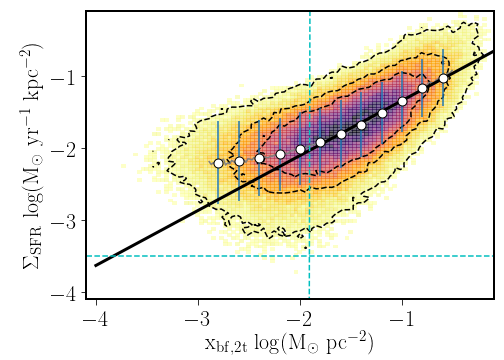

In [162]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

tmp_x  = np.linspace(-4.0,0.0,1000)

host.hist2d(x_plt, y_plt, 
            cmin =10, bins = 200, cmap = 'inferno_r', alpha = 0.6)

mylevels = [0.05, 0.20, 0.40]
host.contour(counts.transpose(), mylevels, 
             extent=(np.nanmin(x_plt),np.nanmax(x_plt),np.nanmin(y_plt),np.nanmax(y_plt)),
             linestyles='dashed', colors = 'k')

host.errorbar(xW_2p2t,yWM_2p2t, yerr = yWS_2p2t, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(xN_2p2t, yNM_2p2t, '0.5', markersize = 9)

host.plot(tmp_x, res_2p2t_binW[1]+res_2p2t_binW[0]*(tmp_x),ls = '-', c = 'black', linewidth = 3.0) 


# Do not delete!
#host.scatter(x_bf_2p2tW[sel2fitW], yWM_SFMS[sel2fitW])

host.plot([-6,6],[-3.5, -3.5],'--c')
host.plot([-1.91,-1.9],[-4.7, 1.7],'--c')

host.set_ylim([-4.1,-0.1])
host.set_xlim([-4.1,-0.1])

host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_xlabel('$\mathrm{x_{bf,2t}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)


In [163]:
sctr_2p2t_all = np.log10(Sigma_SFR_sel*1e6) -  (res_2p2t_lin[1]+res_2p2t_lin[0]*(x_bf_2p2t))
sctr_2p2t_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_2p2t_binW[1]+res_2p2t_binW[0]*(x_bf_2p2t))

# Scatter from narrow medians
idx_tt  = (x_bf_2p2t > paramN_2p2t[1]) & (x_bf_2p2t < paramN_2p2t[2])
x1a_2p2t, y1a_2p2t = x_bf_2p2t[idx_tt], np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1_2p2t = interp(xN_2p2t, yNM_2p2t, x1a_2p2t)
sctr_2p2t_in = y1a_2p2t- yinter1_2p2t

(-0.2, 0.2)

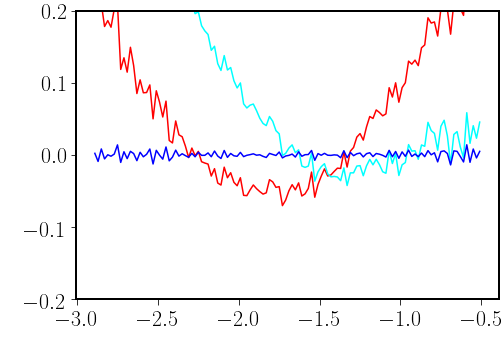

In [164]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN1,yNM1,yNS1 = med(x_bf_2p2t,sctr_2p2t_all,paramN_2p2t)
xN2,yNM2,yNS2 = med(x_bf_2p2t,sctr_2p2t_bin,paramN_2p2t)
xN3,yNM3,yNS3 = med(x1a_2p2t,sctr_2p2t_in,paramN_2p2t)


host.plot(xN1, yNM1, 'red', markersize = 8,  label = 'All data       ')
host.plot(xN2, yNM2, 'cyan', markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue', markersize = 8, label = 'Narrow Medians ')
#host.plot([-13.0, -9.5], [0.0, 0.0], '0.3', linewidth =2,linestyle = '--')

host.set_ylim([-0.2, 0.2])



In [165]:
print('##################' )
print('#####  2p2t ######' )
print('##################' )
print ('Std, variance  all the sample:',   np.std(sctr_2p2t_all), np.var(sctr_2p2t_all))
print ('Std, variance  wide bins     :',   np.std(sctr_2p2t_bin), np.var(sctr_2p2t_bin))
print ('Std, variance  narrow bins   :',   np.nanstd(sctr_2p2t_in), np.nanvar(sctr_2p2t_in))
print('------------------------------------')
limit_Sstar1 = x_bf_2p2t > -1.95
lim_x1a      = x1a_2p2t > -1.95
print ('Std, variance  all the sample wCUT:',   np.std(sctr_2p2t_all[limit_Sstar1]), np.var(sctr_2p2t_all[limit_Sstar1]))
print ('Std, variance  wide bins      wCUT:',   np.std(sctr_2p2t_bin[limit_Sstar1]), np.var(sctr_2p2t_bin[limit_Sstar1]))
print ('Std, variance  narrow bins    wCUT:',   np.nanstd(sctr_2p2t_in[lim_x1a]), np.nanvar(sctr_2p2t_in[lim_x1a]))



##################
#####  2p2t ######
##################
Std, variance  all the sample: 0.4952196804510621 0.24524253190605208
Std, variance  wide bins     : 0.519885501031987 0.27028093418328025
Std, variance  narrow bins   : 0.47165389031971905 0.22245739225372554
------------------------------------
Std, variance  all the sample wCUT: 0.45933194057480864 0.2109858316322195
Std, variance  wide bins      wCUT: 0.4461852101717564 0.1990812417760144
Std, variance  narrow bins    wCUT: 0.4463555458613075 0.1992332733211458


# =============================================================

Text(0.5, 0, '$\\mathrm{x_{bf}}$ $\\log(\\mathrm{M_{\\odot}\\,\\,pc^{-2}})$')

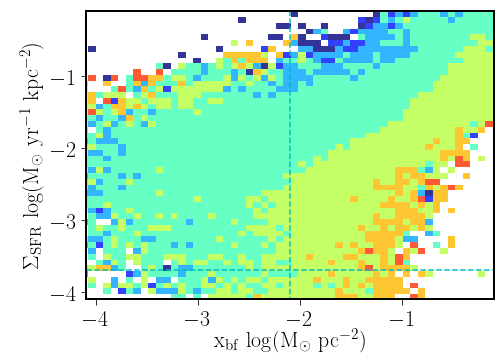

In [166]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

ew_mean2, xedges2, yedges2 = binned_statistic_2d(x_bf, np.log10(Sigma_SFR_sel*1e6), 
                                        np.log10(np.abs(EW[idx_SF][idx1])),
                                        'mean', bins=100)

im = plt.imshow(ew_mean2.T, origin='lower',
           extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]],
           aspect='auto', interpolation='nearest', alpha = 0.8,
           cmap=plt.cm.get_cmap('jet_r', 8),vmin = 0.8, vmax = 2.5)

host.plot([-6,6],[-3.7, -3.7],'--c')
host.plot([-2.1,-2.1],[-4.7, 1.7],'--c')

host.set_ylim([-4.1,-0.1])
host.set_xlim([-4.1,-0.1])

host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_xlabel('$\mathrm{x_{bf}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)



# =============================================================

# ======== Minimization of x =f(S_stelar,S_gas, EW) , fun_3par ==========

# Creating X-axis

In [167]:
x0_EW = [1, 1, 1, 1, 1 ,1.] 

sel2fit = (Sigma_Str_sel*1e6 > 7.5)
res_xbfEW, flag_xbfEW = optimize.leastsq(fun_3par, x0_EW, 
                           args = ([np.log10(Sigma_Str_sel_cgs[sel2fit]), 
                                    np.log10(Sigma_Gas_sel_cgs[sel2fit]),
                                    np.log10(np.abs(EW[idx_SF][idx1][sel2fit]))], 
                                    np.log10(Sigma_SFR_sel[sel2fit]*1e6)))
print(res_xbfEW, flag_xbfEW )

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in power


[-1.85652117e-01 -9.58458120e-02  2.58673276e-06  6.07804050e-01
 -1.57639255e+00  5.62487998e-01] 1


In [168]:
x_bfEW = model_3par(res_xbfEW,
                    [np.log10(Sigma_Str_sel_cgs), 
                     np.log10(Sigma_Gas_sel_cgs), 
                     np.log10(np.abs(EW[idx_SF][idx1]))])


In [181]:
paramW_bfEW = [0.2, -2.9, -1.1]
xW_bfEW,yWM_bfEW,yWS_bfEW   = med(x_bfEW, np.log10(Sigma_SFR_sel*1e6),paramW_bfEW)

paramN_bfEW = [0.02, -2.9, -1.1]
xN_bfEW,yNM_bfEW,yNS_bfEW    = med(x_bfEW, np.log10(Sigma_SFR_sel*1e6),paramN_bfEW)


In [182]:
x0_2p2t  = [1.,1.]
res_bfEW_lin , flag_bfEW_lin  = optimize.leastsq(fun_lin, x0_2p2t , 
                           args = (x_bfEW, 
                                    np.log10(Sigma_SFR_sel*1e6)))

print('BEST FIT  (All data): ',res_bfEW_lin , flag_bfEW_lin)

#=============================================================
selfit = (xW_bfEW > -2.1)
res_bfEW_binW, flag_bfEW_binW = optimize.leastsq(fun_lin, x0_2p2t, 
                           args = (xW_bfEW[selfit],yWM_bfEW[selfit]))

print('BEST FIT (BINS): ',res_bfEW_binW, flag_bfEW_binW)

print(np.min(x_bfEW[sel2fit]))

BEST FIT  (All data):  [ 0.96893718 -0.05902828] 3
BEST FIT (BINS):  [1.2269797  0.39317672] 1
-4.191784791756841


In [183]:
x_plt, y_plt = x_bfEW, np.log10(Sigma_SFR_sel*1e6)
counts, xbins, ybins = np.histogram2d(x_plt, y_plt, bins=150,
                                      normed=True,
                                      range=[[np.nanmin(x_plt),np.nanmax(x_plt)],[np.nanmin(y_plt),np.nanmax(y_plt)]])
counts /= counts.max()

Text(0.5, 0, '$\\mathrm{x_{bf,EW}}$ $\\log(\\mathrm{M_{\\odot}\\,\\,pc^{-2}})$')

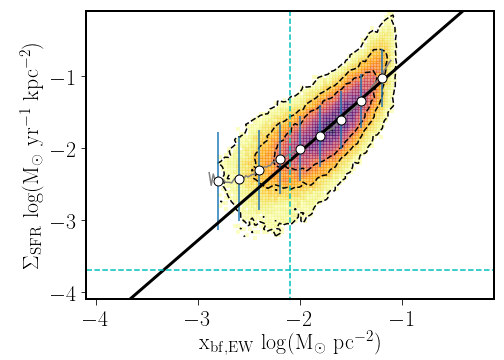

In [184]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])


host.hist2d(x_plt, y_plt, 
            cmin =20, bins = 200, cmap = 'inferno_r', alpha = 0.6)

mylevels = [0.05, 0.20, 0.40]
host.contour(counts.transpose(), mylevels, 
             extent=(np.nanmin(x_plt),np.nanmax(x_plt),np.nanmin(y_plt),np.nanmax(y_plt)),
             linestyles='dashed', colors = 'k')

host.errorbar(xW_bfEW,yWM_bfEW, yerr = yWS_bfEW, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(xN_bfEW, yNM_bfEW, '0.5', markersize = 9)

host.plot(tmp_x, res_bfEW_binW[1]+res_bfEW_binW[0]*(tmp_x),ls = '-', c = 'black', linewidth = 3.0) 

host.plot([-6,6],[-3.7, -3.7],'--c')
host.plot([-2.1,-2.1],[-4.7, 1.7],'--c')

host.set_ylim([-4.1,-0.1])
host.set_xlim([-4.1,-0.1])

host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
host.set_xlabel('$\mathrm{x_{bf,EW}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)


In [178]:
sctr_bfEW_all = np.log10(Sigma_SFR_sel*1e6) -  (res_bfEW_lin[1]+res_bfEW_lin[0]*(x_bfEW))
sctr_bfEW_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_bfEW_binW[1]+res_bfEW_binW[0]*(x_bfEW))

# Scatter from narrow medians
idx_tt  = (x_bfEW > paramN_bfEW[1]) & (x_bfEW < paramN_bfEW[2])
x1a_bfEW, y1a_bfEW = x_bfEW[idx_tt], np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1_bfEW = interp(xN_bfEW, yNM_bfEW, x1a_bfEW)
sctr_bfEW_in = y1a_bfEW- yinter1_bfEW

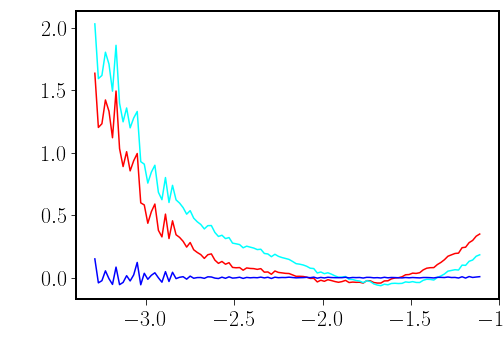

In [179]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN1,yNM1,yNS1 = med(x_bfEW,sctr_bfEW_all,paramN_bfEW)
xN2,yNM2,yNS2 = med(x_bfEW,sctr_bfEW_bin,paramN_bfEW)
xN3,yNM3,yNS3 = med(x1a_bfEW,sctr_bfEW_in,paramN_bfEW)


host.plot(xN1, yNM1, 'red', markersize = 8,  label = 'All data       ')
host.plot(xN2, yNM2, 'cyan', markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue', markersize = 8, label = 'Narrow Medians ')
#host.plot([-13.0, -9.5], [0.0, 0.0], '0.3', linewidth =2,linestyle = '--')

#host.set_ylim([-0.2, 0.2])



In [180]:
print('##################' )
print('##### BF-EW ######' )
print('##################' )
print ('Std, variance  all the sample:',   np.std(sctr_bfEW_all), np.var(sctr_bfEW_all))
print ('Std, variance  wide bins     :',   np.std(sctr_bfEW_bin), np.var(sctr_bfEW_bin))
print ('Std, variance  narrow bins   :',   np.nanstd(sctr_bfEW_in), np.nanvar(sctr_bfEW_in))
print('------------------------------------')
limit_Sstar1 = x_bfEW > -2.6
lim_x1a      = x1a_bfEW > -2.6
print ('Std, variance  all the sample wCUT:',   np.std(sctr_bfEW_all[limit_Sstar1]), np.var(sctr_bfEW_all[limit_Sstar1]))
print ('Std, variance  wide bins      wCUT:',   np.std(sctr_bfEW_bin[limit_Sstar1]), np.var(sctr_bfEW_bin[limit_Sstar1]))
print ('Std, variance  narrow bins    wCUT:',   np.nanstd(sctr_bfEW_in[lim_x1a]), np.nanvar(sctr_bfEW_in[lim_x1a]))


##################
##### BF-EW ######
##################
Std, variance  all the sample: 0.4618743422068593 0.21332790798901896
Std, variance  wide bins     : 0.47350110597066364 0.22420329735544162
Std, variance  narrow bins   : 0.44303579701414325 0.19628071743595712
------------------------------------
Std, variance  all the sample wCUT: 0.4430861691702911 0.19632535331000384
Std, variance  wide bins      wCUT: 0.44393907028199847 0.19708189812284516
Std, variance  narrow bins    wCUT: 0.43306573962848377 0.1875459348399657


# =============================================================

# =============================================================

In [ ]:
paramW_xBF2p2t = [0.1, -11.8, -10.3]
xW_xbf2p2t,yWM_xbf2p2t,yWS_xbf2p2t  = med(xbf_2p2t_sel-9,ybf_2p2t_sel,paramW_xBF2p2t)

paramN_xBF2p2t = [0.01, -12.0, -10.0]
xN_xbf2p2t,yNM_xbf2p2t,yNS_xbf2p2t   = med(xbf_2p2t_sel-9,ybf_2p2t_sel,paramN_xBF)

In [ ]:
x0_lin = [1. ,1.]
res_xbf2p2t_all, flag_xbf2p2t_all = optimize.leastsq(fun_lin, x0_lin, 
                           args = (x_bf_2p2t-9, 
                                    np.log10(Sigma_SFR_sel*1e6)))

print('BEST FIT x_BF (All data): ',res_xbf2p2t_all, flag_xbf2p2t_all)

x0_lin = [1. ,1.]
res_xbf2p2t_binW, flag_xbf2p2t_binW = optimize.leastsq(fun_lin, x0_lin, 
                           args = (xW_xbf2p2t,yWM_xbf2p2t))

print('BEST FIT x_BF (BINS): ', res_xbf2p2t_binW, flag_xbf2p2t_binW)

In [ ]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

tmp_p  = np.linspace(0.0-14,5-14,1000)


host.hist2d(x_bf_2p2t-9, np.log10(Sigma_SFR_sel*1e6), 
            cmin =20, bins = 200, cmap = 'inferno_r', alpha = 0.4)

host.plot((cont_xbf2p2t_60[:,0])-9,cont_xbf2p2t_60[:,1],'--b')
host.plot((cont_xbf2p2t_80[:,0])-9,cont_xbf2p2t_80[:,1],'--b')
host.plot((cont_xbf2p2t_90[:,0])-9,cont_xbf2p2t_90[:,1],'--b')

host.errorbar(xW_xbf2p2t,yWM_xbf2p2t, yerr = yWS_xbf2p2t, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)


host.plot(tmp_p, res_xbf2p2t_all[1]+res_xbf2p2t_all[0]*tmp_p,ls = '-', c = 'blue', linewidth = 3.0) 
host.plot(tmp_p, res_xbf2p2t_binW[1]+res_xbf2p2t_binW[0]*tmp_p,ls = '-', c = 'red', linewidth = 3.0) 

host.set_ylim([-3.7,-0.5])
host.set_xlim([-12.1,-9.7])
host.set_xlabel('$\log(\mathrm{\\Sigma_{b}}\,/\,[\mathrm{M_{\odot}\,\,kpc^{-2}}]\,^2)$', fontsize = 22)
host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)

In [ ]:
sctr_xBF2p2t_all = np.log10(Sigma_SFR_sel*1e6) -  (res_xbf2p2t_all[1]+res_xbf2p2t_all[0]*(x_bf_2p2t-9))
sctr_xBF2p2t_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_xbf2p2t_binW[1]+res_xbf2p2t_binW[0]*(x_bf_2p2t-9))

# Scatter from narrow medians
idx_tt  = (x_bf_2p2t-9 > paramN_xBF2p2t[1]) & (x_bf_2p2t-9 < paramN_xBF2p2t[2])
x1a_xbf2p2t, y1a_xbf2p2t = x_bf_2p2t[idx_tt]-9,np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1_bf2p2t = interp(xN_xbf2p2t, yNM_xbf2p2t, x1a_xbf2p2t)
sctr_xBF2p2t_in = y1a_xbf2p2t- yinter1_bf2p2t

In [ ]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN1,yNM1,yNS1 = med(x_bf_2p2t-9,sctr_xBF2p2t_all,paramN_xBF2p2t)
xN2,yNM2,yNS2 = med(x_bf_2p2t-9,sctr_xBF2p2t_bin,paramN_xBF2p2t)
xN3,yNM3,yNS3 = med(x1a_xbf2p2t,sctr_xBF2p2t_in,paramN_xBF2p2t)


host.plot(xN1, yNM1, 'red', markersize = 8,  label = 'All data       ')
host.plot(xN2, yNM2, 'cyan', markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue', markersize = 8, label = 'Narrow Medians ')
host.plot([-13.0, -9.5], [0.0, 0.0], '0.3', linewidth =2,linestyle = '--')

host.set_ylim([-0.2, 0.2])
host.set_xlim([ -11.7,-10.3])

host.set_ylabel('$\\Delta_\mathrm{SF-BF}$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{bf}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)
host.legend()

## Standard Deviation of the residuals

In [ ]:
print('##################' )
print('### XBF_2P2T  ####' )
print('##################' )
print ('Std, variance  all the sample', np.std(sctr_xBF2p2t_all) ,   np.var(sctr_xBF2p2t_all))
print ('Std, variance  wide bins     ', np.std(sctr_xBF2p2t_bin) ,   np.var(sctr_xBF2p2t_bin))
print ('Std, variance  narrow bins   ', np.nanstd(sctr_xBF2p2t_in),  np.nanvar(sctr_xBF2p2t_in))

In [ ]:
stat_pea_SFR_XBF2p2t, pea_SFR_XBF2p2t = pearsonr  ( x_bf_2p2t-9, np.log10(Sigma_SFR_sel*1e6))
stat_spe_SFR_XBF2p2t, spe_SFR_XBF2p2t = spearmanr ( x_bf_2p2t-9, np.log10(Sigma_SFR_sel*1e6))
stat_ken_SFR_XBF2p2t, ken_SFR_XBF2p2t = kendalltau( x_bf_2p2t-9, np.log10(Sigma_SFR_sel*1e6))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   SFR-XBF:', stat_pea_SFR_XBF2p2t, pea_SFR_XBF2p2t)
print(' Spearman SFR-XBF:', stat_spe_SFR_XBF2p2t, spe_SFR_XBF2p2t)
print(' Kendall  SFR-XBF:', stat_ken_SFR_XBF2p2t, ken_SFR_XBF2p2t)

In [ ]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

ew_mean2, xedges2, yedges2 = binned_statistic_2d(x_bf_2p2t[ibf_2p2t_sel]-9, np.log10(Sigma_SFR_sel[ibf_2p2t_sel]*1e6), 
                                        np.log10(np.abs(EW[idx_SF][idx1][ibf_2p2t_sel])),
                                        'mean', bins=100)

im = plt.imshow(ew_mean2.T, origin='lower',
           extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]],
           aspect='auto', interpolation='nearest', alpha = 0.8,
           cmap=plt.cm.get_cmap('jet_r', 8),vmin = 0.8, vmax = 1.9)

host.plot((cont_xbf2p2t_60[:,0])-9,cont_xbf2p2t_60[:,1],'--b')
host.plot((cont_xbf2p2t_80[:,0])-9,cont_xbf2p2t_80[:,1],'--b')
host.plot((cont_xbf2p2t_90[:,0])-9,cont_xbf2p2t_90[:,1],'--b')

host.errorbar(xW_xbf2p2t,yWM_xbf2p2t, yerr = yWS_xbf2p2t, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)
host.plot(tmp_p, res_xbf2p2t_binW[1]+res_xbf2p2t_binW[0]*tmp_p,ls = '--', c = 'red', linewidth = 3.0) 
host.plot(tmp_p, res_xbf2p2t_all[1]+res_xbf2p2t_all[0]*tmp_p,ls = '-', c = 'blue', linewidth = 3.0) 

cbar_ax = fig.add_axes([0.59, 0.25, 0.35, 0.03]) 
cbar    = plt.colorbar(im, cax=cbar_ax, ticks= [0.9, 1.4, 1.9], orientation='horizontal') 
cbar.ax.set_title('$\mathrm{\log(EW(H\\alpha)})$', fontsize= 18)

host.set_ylim([-3.7,-0.5])
host.set_xlim([-12.1,-9.7])
host.set_xlabel('$\log(\mathrm{\\Sigma_{b}}\,/\,[\mathrm{M_{\odot}\,\,kpc^{-2}}]\,^2)$', fontsize = 22)
host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)


# ======== Minimization of x =f(S_stelar,S_gas, EW) , fun_3par ==========

## Creating the X-AXIS 

In [ ]:
# You have to force the initial guess to those derived by fun_2par
x0_EW = [-0.1424375,   0.45150804,  0.96011451, 1, 1 ,1.] 
res_xbfEW, flag_xbfEW = optimize.leastsq(fun_3par, x0_EW, 
                           args = ([np.log10(Sigma_Str_sel_cgs), 
                                    np.log10(Sigma_Gas_sel_cgs),
                                    np.log10(np.abs(EW[idx_SF][idx1]))], 
                                    np.log10(Sigma_SFR_sel*1e6)))
print(res_xbfEW, flag_xbfEW )

In [ ]:
x_bfEW = model_3par(res_xbfEW,
                    [np.log10(Sigma_Str_sel_cgs), 
                     np.log10(Sigma_Gas_sel_cgs), 
                     np.log10(np.abs(EW[idx_SF][idx1]))])


In [ ]:
# Select 80% sample
xbfEW_sel, ybfEW_sel, ibfEW_sel, cbfEW_sel = sel2dContour_Open(x_bfEW, np.log10(Sigma_SFR_sel*1e6),ld = True)

In [ ]:
path_xbfEW_90, path_xbfEW_80, path_xbfEW_60 = cbfEW_sel.collections[0].get_paths()[0],\
cbfEW_sel.collections[1].get_paths()[0], cbfEW_sel.collections[2].get_paths()[0]
cont_xbfEW_90, cont_xbfEW_80, cont_xbfEW_60 = path_xbfEW_90.vertices, path_xbfEW_80.vertices, path_xbfEW_60.vertices

In [ ]:
paramW_xBFEW = [0.1, -11.6, -10.5]
xW_xbfEW,yWM_xbfEW,yWS_xbfEW  = med(xbfEW_sel-9,ybfEW_sel,paramW_xBFEW)

paramN_xBFEW = [0.01, -11.6, -10.5]
xN_xbfEW,yNM_xbfEW,yNS_xbfEW   = med(xbfEW_sel-9,ybfEW_sel,paramN_xBFEW)

In [ ]:
x0_lin = [1. ,1.]
res_xbfEW_all, flag_xbfEW_all = optimize.leastsq(fun_lin, x0_lin, 
                           args = (x_bfEW-9, 
                                    np.log10(Sigma_SFR_sel*1e6)))

print('BEST FIT x_BF_EW (All data): ',res_xbfEW_all, flag_xbfEW_all)

x0_lin = [1. ,1.]
res_xbfEW_binW, flag_xbfEW_binW = optimize.leastsq(fun_lin, x0_lin, 
                           args = (xW_xbfEW,yWM_xbfEW))

print('BEST FIT x_BF_EW (BINS): ', res_xbfEW_binW, flag_xbfEW_binW)

In [ ]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

tmp_p  = np.linspace(0.0-14,5-14,1000)

host.hist2d(x_bfEW-9, np.log10(Sigma_SFR_sel*1e6), 
            cmin =20, bins = 200, cmap = 'inferno_r', alpha = 0.4)

host.plot((cont_xbfEW_60[:,0])-9,cont_xbfEW_60[:,1],'--b')
host.plot((cont_xbfEW_80[:,0])-9,cont_xbfEW_80[:,1],'--b')
host.plot((cont_xbfEW_90[:,0])-9,cont_xbfEW_90[:,1],'--b')

host.errorbar(xW_xbfEW,yWM_xbfEW, yerr = yWS_xbfEW, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(tmp_p, res_xbfEW_binW[1]+res_xbfEW_binW[0]*tmp_p,ls = '-', c = 'blue', linewidth = 3.0) 

host.set_ylim([-3.7,-0.2])
host.set_xlim([-12.2,-9.2])
host.set_xlabel('$\mathrm{P_{h}}\,\log(\mathrm{dyn\,\,cm^{-2} })$', fontsize = 22)
host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)


## Residuals w.r.t the X-BF 

In [ ]:
sctr_xBFEW_all = np.log10(Sigma_SFR_sel*1e6) -  (res_xbfEW_all[1]+res_xbfEW_all[0]*(x_bfEW-9))
sctr_xBFEW_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_xbfEW_binW[1]+res_xbfEW_binW[0]*(x_bfEW-9))

# Scatter from narrow medians
idx_tt  = (x_bfEW-9 > paramN_xBFEW[1]) & (x_bfEW-9 < paramN_xBFEW[2])
x1a_xbfEW, y1a_xbfEW = x_bfEW[idx_tt]-9,np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1_bfEW = interp(xN_xbfEW, yNM_xbfEW, x1a_xbfEW)
sctr_xBFEW_in = y1a_xbfEW- yinter1_bfEW

In [ ]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN1,yNM1,yNS1 = med(x_bfEW-9,sctr_xBFEW_all,paramN_xBFEW)
xN2,yNM2,yNS2 = med(x_bfEW-9,sctr_xBFEW_bin,paramN_xBFEW)
xN3,yNM3,yNS3 = med(x1a_xbfEW,sctr_xBFEW_in,paramN_xBFEW)


host.plot(xN1, yNM1, 'red', markersize = 8,  label = 'All data       ')
host.plot(xN2, yNM2, 'cyan', markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue', markersize = 8, label = 'Narrow Medians ')
host.plot([-13.0, -9.5], [0.0, 0.0], '0.3', linewidth =2,linestyle = '--')

host.set_ylim([-0.2, 0.2])
host.set_xlim([ -11.7,-10.3])

host.set_ylabel('$\\Delta_\mathrm{SF-BF-EW}$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{bf}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)
host.legend()

## Standard Deviation of the residuals 

In [ ]:
print('##################' )
print('####  XBF EW #####' )
print('##################' )
print ('Std, variance  all the sample', np.std(sctr_xBFEW_all) ,   np.var(sctr_xBFEW_all))
print ('Std, variance  wide bins     ', np.std(sctr_xBFEW_bin) ,   np.var(sctr_xBFEW_bin))
print ('Std, variance  narrow bins   ', np.nanstd(sctr_xBFEW_in),  np.nanvar(sctr_xBFEW_in))

In [ ]:
stat_pea_SFR_XBFEW, pea_SFR_XBFEW = pearsonr  ( x_bfEW-9, np.log10(Sigma_SFR_sel*1e6))
stat_spe_SFR_XBFEW, spe_SFR_XBFEW = spearmanr ( x_bfEW-9, np.log10(Sigma_SFR_sel*1e6))
stat_ken_SFR_XBFEW, ken_SFR_XBFEW = kendalltau( x_bfEW-9, np.log10(Sigma_SFR_sel*1e6))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   SFR-XBF:', stat_pea_SFR_XBFEW, pea_SFR_XBFEW)
print(' Spearman SFR-XBF:', stat_spe_SFR_XBFEW, spe_SFR_XBFEW)
print(' Kendall  SFR-XBF:', stat_ken_SFR_XBFEW, ken_SFR_XBFEW)

## SFR - X_BF (EW) color coded w.r.t EW(Ha)

In [ ]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

ew_mean3, xedges3, yedges3 = binned_statistic_2d(x_bfEW[ibfEW_sel]-9, np.log10(Sigma_SFR_sel[ibfEW_sel]*1e6), 
                                        np.log10(np.abs(EW[idx_SF][idx1][ibfEW_sel])),
                                        'mean', bins=100)

im = plt.imshow(ew_mean3.T, origin='lower',
           extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]],
           aspect='auto', interpolation='nearest', alpha = 0.8,
           cmap=plt.cm.get_cmap('jet_r', 8),vmin = 0.8, vmax = 1.9)


host.errorbar(xW_xbfEW,yWM_xbfEW, yerr = yWS_xbfEW, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)
host.plot(tmp_p, res_xbfEW_binW[1]+res_xbfEW_binW[0]*tmp_p,ls = '--', c = 'red', linewidth = 3.0) 
host.plot(tmp_p, res_xbfEW_all[1]+res_xbfEW_all[0]*tmp_p,ls = '-', c = 'blue', linewidth = 3.0) 
#host.plot(tmp_p, 13.4+1.4*tmp_p,ls = '-', c = 'blue', linewidth = 3.0) 



cbar_ax = fig.add_axes([0.59, 0.25, 0.35, 0.03]) 
cbar    = plt.colorbar(im, cax=cbar_ax, ticks= [0.9, 1.4, 1.9], orientation='horizontal') 
cbar.ax.set_title('$\mathrm{\log(EW(H\\alpha)})$', fontsize= 18)


host.set_ylim([-3.7,-0.5])
host.set_xlim([-11.8,-10.0])
host.set_xlabel('$\log(\mathrm{\\Sigma_{b}}\,/\,[\mathrm{M_{\odot}\,\,kpc^{-2}}]\,^2)$', fontsize = 22)
host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)

In [ ]:

fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.19, width, hight])

# Fake x-axis
tmp_p  = np.linspace(0.0-14,5-14,1000)

host.hist2d(x_bfEW-9, np.log10(Sigma_SFR_sel*1e6), 
            cmin =20, bins = 200, cmap = 'inferno_r', alpha = 0.7)

host.plot((cont_xbf_60[:,0])-9,cont_xbf_60[:,1],'--k', alpha = 0.3)
host.plot((cont_xbf_80[:,0])-9,cont_xbf_80[:,1],'--k', alpha = 0.3)
host.plot((cont_xbf_90[:,0])-9,cont_xbf_90[:,1],'--k', alpha = 0.3)

host.plot((cont_xbfEW_60[:,0])-9,cont_xbfEW_60[:,1],'--b')
host.plot((cont_xbfEW_80[:,0])-9,cont_xbfEW_80[:,1],'--b')
host.plot((cont_xbfEW_90[:,0])-9,cont_xbfEW_90[:,1],'--b')

# host.errorbar(xW_xbfEW,yWM_xbfEW, yerr = yWS_xbfEW, 
#               markerfacecolor ='white', markeredgecolor = 'black', 
#               fmt = 'o', markersize = 9)
# host.plot(tmp_p, res_xbfEW_binW[1]+res_xbfEW_binW[0]*tmp_p,ls = '--', c = 'red', linewidth = 3.0) 
host.plot(tmp_p, res_xbfEW_all[1]+res_xbfEW_all[0]*tmp_p,ls = '-', c = 'blue', linewidth = 3.0) 

host.set_ylim([-3.7,-0.2])
host.set_xlim([-12.3,-9.4])
host.set_xlabel('$\log(\mathrm{\\Sigma_{b,EW(H\\alpha)}})$', fontsize = 22)
host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)
# plt.savefig('plots/SFR_Ha_xbfEW_V0.pdf')

# Minimization of x =f(S_gas,S_stellar, EW) , fun_3par_2ter

In [ ]:
x0_EW_3p2t = [1., 1., 1., 1. ,1.]
res_xbfEW_3p2t, flag_xbfEW_3p2t = optimize.leastsq(fun_3par_2ter, x0_EW_3p2t, 
                           args = ([np.log10(Sigma_Gas_sel_cgs), 
                                    np.log10(Sigma_Str_sel_cgs),
                                    np.log10(np.abs(EW[idx_SF][idx1]))],
                                   np.log10(Sigma_SFR_sel*1e6)))
print(res_xbfEW_3p2t, flag_xbfEW_3p2t)

In [ ]:
x_bfEW_3p2t = model_3par_2ter(res_xbfEW_3p2t,[np.log10(Sigma_Gas_sel_cgs), 
                                        np.log10(Sigma_Str_sel_cgs), 
                                        np.log10(np.abs(EW[idx_SF][idx1]))])

In [ ]:
# Select 80% sample
xbfEW3p2t_sel, ybfEW3p2t_sel, ibfEW3p2t_sel, cbfEW3p2t_sel = sel2dContour_Open(x_bfEW_3p2t, np.log10(Sigma_SFR_sel*1e6),ld = True)


In [ ]:
path_xbfEW3p2t_90, path_xbfEW3p2t_80, path_xbfEW3p2t_60 = cbfEW3p2t_sel.collections[0].get_paths()[0],\
cbfEW3p2t_sel.collections[1].get_paths()[0], cbfEW3p2t_sel.collections[2].get_paths()[0]
cont_xbfEW3p2t_90, cont_xbfEW3p2t_80, cont_xbfEW3p2t_60 = path_xbfEW3p2t_90.vertices, path_xbfEW3p2t_80.vertices, path_xbfEW3p2t_60.vertices

In [ ]:
paramW_xBFEW3p2t = [0.1, -11.6, -10.5]
xW_xbfEW3p2t,yWM_xbfEW3p2t,yWS_xbfEW3p2t  = med(xbfEW3p2t_sel-9,ybfEW3p2t_sel,paramW_xBFEW3p2t)

paramN_xBFEW3p2t = [0.01, -11.6, -10.5]
xN_xbfEW3p2t,yNM_xbfEW3p2t,yNS_xbfEW3p2t   = med(xbfEW3p2t_sel-9,ybfEW3p2t_sel,paramN_xBFEW3p2t)

In [ ]:
x0_lin = [1. ,1.]
res_xbfEW3p2t_all, flag_xbfEW3p2t_all = optimize.leastsq(fun_lin, x0_lin, 
                           args = (x_bfEW_3p2t-9, 
                                    np.log10(Sigma_SFR_sel*1e6)))

print('BEST FIT x_BF_EW (All data): ',res_xbfEW3p2t_all, flag_xbfEW3p2t_all)

x0_lin = [1. ,1.]
res_xbfEW3p2t_binW, flag_xbfEW3p2t_binW = optimize.leastsq(fun_lin, x0_lin, 
                           args = (xW_xbfEW3p2t,yWM_xbfEW3p2t))

print('BEST FIT x_BF_EW (BINS): ', res_xbfEW3p2t_binW, flag_xbfEW3p2t_binW)

In [ ]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

tmp_p  = np.linspace(0.0-14,5-14,1000)

host.hist2d(x_bfEW_3p2t-9, np.log10(Sigma_SFR_sel*1e6), 
            cmin =20, bins = 200, cmap = 'inferno_r', alpha = 0.4)

host.plot((cont_xbfEW3p2t_60[:,0])-9,cont_xbfEW3p2t_60[:,1],'--b')
host.plot((cont_xbfEW3p2t_80[:,0])-9,cont_xbfEW3p2t_80[:,1],'--b')
host.plot((cont_xbfEW3p2t_90[:,0])-9,cont_xbfEW3p2t_90[:,1],'--b')

host.errorbar(xW_xbfEW3p2t,yWM_xbfEW3p2t, yerr = yWS_xbfEW3p2t, 
              markerfacecolor ='white', markeredgecolor = 'black', 
              fmt = 'o', markersize = 9)

host.plot(tmp_p, res_xbfEW3p2t_binW[1]+res_xbfEW3p2t_binW[0]*tmp_p,ls = '-', c = 'blue', linewidth = 3.0) 

host.set_ylim([-3.7,-0.2])
host.set_xlim([-12.2,-9.2])
host.set_xlabel('$\mathrm{P_{h}}\,\log(\mathrm{dyn\,\,cm^{-2} })$', fontsize = 22)
host.set_ylabel('$\Sigma_\mathrm{SFR}\,\log(\mathrm{M_{\odot}\,\,yr^{-1}\,\,kpc^{-2} })$', fontsize = 22)

In [ ]:
# Residuals w.r.t to XBF EW 3p2t

In [ ]:
sctr_xBFEW3p2t_all = np.log10(Sigma_SFR_sel*1e6) -  (res_xbfEW3p2t_all[1]+res_xbfEW3p2t_all[0]*(x_bfEW_3p2t-9))
sctr_xBFEW3p2t_bin = np.log10(Sigma_SFR_sel*1e6) -  (res_xbfEW3p2t_binW[1]+res_xbfEW3p2t_binW[0]*(x_bfEW_3p2t-9))

# Scatter from narrow medians
idx_tt  = (x_bfEW_3p2t-9 > paramN_xBFEW3p2t[1]) & (x_bfEW_3p2t-9 < paramN_xBFEW3p2t[2])
x1a_xbfEW3p2t, y1a_xbfEW3p2t = x_bfEW_3p2t[idx_tt]-9,np.log10(Sigma_SFR_sel[idx_tt]*1e6)
yinter1_bfEW3p2t = interp(xN_xbfEW3p2t, yNM_xbfEW3p2t, x1a_xbfEW3p2t)
sctr_xBFEW3p2t_in = y1a_xbfEW3p2t- yinter1_bfEW3p2t

In [ ]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.84, 0.80
host  = plt.axes([0.15, 0.17, width, hight])


xN1,yNM1,yNS1 = med(x_bfEW_3p2t-9,sctr_xBFEW3p2t_all,paramN_xBFEW3p2t)
xN2,yNM2,yNS2 = med(x_bfEW_3p2t-9,sctr_xBFEW3p2t_bin,paramN_xBFEW3p2t)
xN3,yNM3,yNS3 = med(x1a_xbfEW3p2t,sctr_xBFEW3p2t_in,paramN_xBFEW3p2t)


host.plot(xN1, yNM1, 'red', markersize = 8,  label = 'All data       ')
host.plot(xN2, yNM2, 'cyan', markersize = 8, label = 'Wide Medians   ')
host.plot(xN3, yNM3, 'blue', markersize = 8, label = 'Narrow Medians ')
host.plot([-13.0, -9.5], [0.0, 0.0], '0.3', linewidth =2,linestyle = '--')

host.set_ylim([-0.2, 0.2])
host.set_xlim([ -11.7,-10.3])

host.set_ylabel('$\\Delta_\mathrm{SF-BF-EW-3p2t}$', fontsize = 22)
host.set_xlabel('$\mathrm{\\Sigma_{bf}}$ $\log(\mathrm{M_{\odot}\,\,pc^{-2}})$', fontsize= 22)
host.legend()

In [ ]:
print('##################' )
print('### XBF EW 3p2t ##' )
print('##################' )
print ('Std, variance  all the sample', np.std(sctr_xBFEW3p2t_all) ,   np.var(sctr_xBFEW3p2t_all))
print ('Std, variance  wide bins     ', np.std(sctr_xBFEW3p2t_bin) ,   np.var(sctr_xBFEW3p2t_bin))
print ('Std, variance  narrow bins   ', np.nanstd(sctr_xBFEW3p2t_in),  np.nanvar(sctr_xBFEW3p2t_in))

In [ ]:
stat_pea_SFR_XBFEW_3p2t, pea_SFR_XBFEW_3p2t = pearsonr  ( x_bfEW_3p2t-9, np.log10(Sigma_SFR_sel*1e6))
stat_spe_SFR_XBFEW_3p2t, spe_SFR_XBFEW_3p2t = spearmanr ( x_bfEW_3p2t-9, np.log10(Sigma_SFR_sel*1e6))
stat_ken_SFR_XBFEW_3p2t, ken_SFR_XBFEW_3p2t = kendalltau( x_bfEW_3p2t-9, np.log10(Sigma_SFR_sel*1e6))
#chi2_SFR_Gas, pchi_SFR_Gas, dof_SFR_Gas = chi2_contingency([np.log10(Sigma_Gas_sel),np.abs(np.log10(Sigma_SFR_sel*1e6))])


print(' Person   SFR-XBF:', stat_pea_SFR_XBFEW_3p2t, pea_SFR_XBFEW_3p2t)
print(' Spearman SFR-XBF:', stat_spe_SFR_XBFEW_3p2t, spe_SFR_XBFEW_3p2t)
print(' Kendall  SFR-XBF:', stat_ken_SFR_XBFEW_3p2t, ken_SFR_XBFEW_3p2t)

In [ ]:
fig = plt.figure(figsize=(7.0,5.0))
width, hight = 0.81, 0.80
host  = plt.axes([0.17, 0.17, width, hight])

# Fake x-axis
tmp_p  = np.linspace(0.0-14,5-14,1000)

host.hist2d(x_bfEW_3p2t-9, np.log10(Sigma_SFR_sel*1e6), 
            cmin =20, bins = 200, cmap = 'inferno_r', alpha = 0.7)

host.plot((cont_xbf2p2t_60[:,0])-9,cont_xbf2p2t_60[:,1],'--b')
host.plot((cont_xbf2p2t_80[:,0])-9,cont_xbf2p2t_80[:,1],'--b')
host.plot((cont_xbf2p2t_90[:,0])-9,cont_xbf2p2t_90[:,1],'--b')

host.set_ylim([-3.7,-0.2])
host.set_xlim([-12.3,-9.1])
host.set_xlabel('$\log(\mathrm{\\Sigma_{b}}\,/\,[\mathrm{M_{\odot}\,\,kpc^{-2}}]\,^2)$', fontsize = 22)



# Correlation Factor Compilation

In [ ]:
print('Correlation Compilation $\\Sigma_{SFR}$')
print(' ')
print('$\\Sigma_{gas}    $',stat_pea_SFR_Gas)
print('$\\Sigma_{stellar}$',stat_pea_SFR_Str)
print('$EW(H\\alpha)$     ',stat_pea_SFR_EW )
print('$\\Sigma_{b}}$     ',stat_pea_SFR_XBF)
print('$\\Sigma_{b, EW}}$ ',stat_pea_SFR_XBFEW)
print('$\\Sigma_{b2p}$    ',stat_pea_SFR_XBF2p2t)
print('$\\Sigma_{b2p,EW}}$',stat_pea_SFR_XBFEW_3p2t)

# Scatter and Variance Compilation

In [ ]:
print('Correlation Compilation $\\Sigma_{SFR}$')
print(' ')
print(' SFMS ', np.nanstd(sctr_rSFMS_bin), np.nanvar(sctr_rSFMS_bin))
print(' KSL  ', np.nanstd(sctr_rKSL_bin) , np.nanvar(sctr_rKSL_bin))
print(' EW   ', np.nanstd(sctr_rEW_bin)  , np.nanvar(sctr_rEW_bin))
print(' ')
print(' SBL  ', np.nanstd(sctr_xBF_bin)  , np.nanvar(sctr_xBF_bin))
print('SBL-EW', np.nanstd(sctr_xBFEW_bin), np.nanvar(sctr_xBFEW_bin))
print(' ')
print('SBL-2p    ', np.nanstd(sctr_xBF2p2t_in), np.nanvar(sctr_xBF2p2t_in))
print('SBL-2p-EW ', np.nanstd(sctr_xBFEW3p2t_in), np.nanvar(sctr_xBFEW3p2t_in))


# Fitting factors compilation

In [ ]:
print('best fitting factors Compilation')
print(' SFMS  ' , res_rSFMS_binW)
print(' KSL   ' , res_rKSL_binW )
print(' EW    ' , res_rEW_binW  )
print(' XBF   ' , res_xbf_binW  )
print(' XBF-EW' , res_xbfEW_binW)
print(' ')
print('SBL-2p    ', res_xbf2p2t_binW)
print('SBL-2p-EW ', res_xbfEW3p2t_binW)